
# Data-driven optimisation of a multi-stage pumping network 

This notebook demonstrates a **data-driven control strategy** for an industrial water distribution system — for instance, a multi-stage pumping network that supplies cooling water to a **nuclear or thermal power facility**.

The control objective is to **meet a time-varying water demand** at the downstream end of the network while:

* Keeping all reservoir levels within **30 – 90 % of capacity**,

* Minimising **pump switching events** (to reduce mechanical wear and electrical load), and

* Reducing **energy consumption**.

Over a **48-hour demand segment**, two controllers are implemented and compared:

## 1. Proportional-Control Heuristic

A rule-based controller that adjusts the number of active pumps based on downstream demand and reservoir level deviations.
It penalises excessive switching and uses a safety mask to prevent level violations.

## 2. Reinforcement-Learning (RL) Controller

A tabular Q-Learning agent that jointly controls all pump stations.
It receives penalties for unmet demand, level violations, switching, and energy use, and includes a **safety layer** that overrides unsafe actions.

Training is performed with slightly stricter safety bounds to encourage conservative behaviour, ensuring that the final policy respects the operational limits under evaluation.



## Import libraries and load data

In [2]:

import json
from typing import (Iterable, Iterator,  Dict, List, Optional, Tuple, Any)
from pathlib import Path
import random
import copy
from contextlib import contextmanager
from itertools import product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

from src.hydro_control_rl_optimiser.cooling_control import (PumpingRegime, CoolingLoopSimulator, heuristic_controller, compute_switch_count)
from src.hydro_control_rl_optimiser.rl_cooling_control import (FullStateDiscretiser, FullQLearningAgent, full_train_agent, full_evaluate_agent)
from src.hydro_control_rl_optimiser.plots_and_reports import (build_and_plot_all, format_global_search_report, compute_all_stats, print_summary)

try:
    from joblib import Parallel, delayed
except Exception:  # graceful fallback if joblib not installed
    Parallel = None
    def delayed(fn): return fn  # type: ignore
    print('joblib not installed')


# Ensure plots appear inline
%matplotlib inline


# Load pumping regimes and demand data
with open('./data/pumping_profiles.json', 'r') as f:
    regimes_data = json.load(f)

# Extract pumping regimes and demand levels
regimes_list = []
demand_map = {}
for key, value in regimes_data.items():
    if key == 'Demand':
        demand_map = {int(k): float(v) for k, v in value['Flow Rate (m3/h)'].items()}
    else:
        regimes_list.append(value)

# Load minute-by-minute demand time series
demand_df = pd.read_csv('./data/demand_profile.csv')
# Take a 48-hour segment for evaluation (2,880 minutes)
segment_length = 48 * 60
demand_segment = demand_df['Demand'].iloc[:segment_length].to_list()

print(f"Loaded {len(demand_segment)} minutes of demand data for evaluation.")


Loaded 2880 minutes of demand data for evaluation.


## Define utility functions

In [6]:
def count_switches_actions(actions: List[Tuple[int, ...]]) -> int:
    """Return total per-station switch events for an RL action sequence of tuples."""
    if not actions:
        return 0
    switches = 0
    prev = actions[0]
    for curr in actions[1:]:
        switches += sum(int(c != p) for c, p in zip(curr, prev))
        prev = curr
    return switches


def count_switches_schedule(pump_history: List[List[int]]) -> int:
    """Return total per-station switch events for a heuristic pump schedule."""
    if not pump_history:
        return 0
    switches = 0
    prev = pump_history[0]
    for curr in pump_history[1:]:
        switches += sum(int(c != p) for c, p in zip(curr, prev))
        prev = curr
    return switches


def prepare_regimes(regimes_list: List[dict]) -> List["PumpingRegime"]:
    """Create and consistently order PumpingRegime objects from dictionaries."""
    regimes_obj = [PumpingRegime.from_dict(item) for item in regimes_list]
    regimes_obj.sort(key=lambda r: r.flow_rates[1])
    return regimes_obj


def to_levels_array(levels_hist: Iterable[Iterable[float]]) -> np.ndarray:
    """Convert levels history to a numeric array, dropping a leading index/time column if detected."""
    arr = np.asarray(levels_hist)
    if arr.ndim == 2 and arr.shape[1] >= 2:
        col0 = arr[:, 0]
        if np.all(np.isfinite(col0)) and np.all(np.diff(col0) >= 0):
            return arr[:, 1:]
    return arr


def extract_had_violation(info: Any) -> bool:
    """Best-effort extraction of a violation flag from a controller 'info' payload."""
    if info is None:
        return False
    if isinstance(info, dict):
        if "had_violation" in info:
            return bool(info["had_violation"])
        candidate_flags = (
            "violation", "violations", "any_violation",
            "unmet_demand", "level_violation", "overflow", "underflow", "safety_violation"
        )
        return any(bool(info.get(k, False)) for k in candidate_flags)
    if isinstance(info, (list, tuple)):
        return any(extract_had_violation(x) for x in info)
    return bool(info)

def make_violation_info(
    levels_history: Iterable[Iterable[float]],
    lower_limit: float,
    upper_limit: float,
    tol: float = 0.0
) -> Dict[str, Any]:
    """Summarise bound violations for a levels time-series and return an info dict."""
    arr = np.asarray(levels_history, dtype=float)
    if arr.ndim == 1:
        arr = arr.reshape(-1, 1)
    lower = lower_limit - tol
    upper = upper_limit + tol
    viol_mask = (arr < lower) | (arr > upper)
    violation_steps = np.where(viol_mask.any(axis=1))[0].tolist()
    per_tank_counts = viol_mask.sum(axis=0).astype(int).tolist()
    return {
        "had_violation": bool(len(violation_steps) > 0),
        "violation_steps": violation_steps,
        "violation_counts_per_tank": per_tank_counts,
        "bounds": {"lower": float(lower_limit), "upper": float(upper_limit), "tol": float(tol)},
        "total_violations": int(viol_mask.sum())
    }


@contextmanager
def temp_seed(seed: int) -> Iterator[None]:
    """Temporarily set numpy and Python RNG seeds; restore previous states after the block."""
    state_np = np.random.get_state()
    state_py = random.getstate()
    np.random.seed(seed)
    random.seed(seed)
    try:
        yield
    finally:
        np.random.set_state(state_np)
        random.setstate(state_py)


def outer_time_series_splits(
    n_samples: int,
    train_len: int,
    test_len: int,
    n_splits: int,
    gap: int = 0
) -> Iterator[Tuple[np.ndarray, np.ndarray]]:
    """Yield chronological outer (train_idx, test_idx) with fixed train and test window sizes."""
    splitter = TimeSeriesSplit(
        n_splits=n_splits,
        max_train_size=train_len,
        test_size=test_len,
        gap=gap
    )
    for train_idx, test_idx in splitter.split(np.arange(n_samples)):
        yield train_idx, test_idx


def inner_time_series_splits(
    train_idx: np.ndarray,
    val_fraction: float = 0.25,
    n_inner_splits: int = 3,
    gap: int = 0
) -> Iterator[Tuple[np.ndarray, np.ndarray]]:
    """Yield inner (train_inner_idx, val_idx) folds inside one outer training window using rolling splits."""
    outer_train_len = len(train_idx)
    val_len = max(1, int(round(outer_train_len * val_fraction)))
    max_train_size = outer_train_len - val_len
    splitter = TimeSeriesSplit(
        n_splits=n_inner_splits,
        max_train_size=max_train_size,
        test_size=val_len,
        gap=gap
    )
    for tr_rel, va_rel in splitter.split(train_idx):
        yield train_idx[tr_rel], train_idx[va_rel]


def last_quarter_holdout(train_idx: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Return a simple time-ordered split: first 75% for fitting, last 25% for validation."""
    split = int(round(len(train_idx) * 0.75))
    return train_idx[:split], train_idx[split:]


def build_action_map_from_regimes(regimes: List["PumpingRegime"]) -> List[Tuple[int, ...]]:
    """Return the Cartesian product of available pump counts per station."""
    per_station = [sorted(reg.flow_rates.keys()) for reg in regimes]
    return list(product(*per_station))


def simulate_one_step_levels(
    sim: "CoolingLoopSimulator",
    action: Tuple[int, ...],
    demand: float
) -> np.ndarray:
    """Return next-step levels (R-2..R-5) after applying `action` at `demand`, without mutating `sim`."""
    sim_tmp = copy.deepcopy(sim)
    sim_tmp.step(list(action), demand)
    return np.asarray(sim_tmp.get_levels()[1:], dtype=float)


def build_safe_action_set(
    sim: "CoolingLoopSimulator",
    demand: float,
    action_map: List[Tuple[int, ...]],
    lower_limit: float,
    upper_limit: float
) -> Tuple[List[int], Optional[int]]:
    """Return (indices_of_safe_actions, index_of_least_unsafe_action)."""
    safe_indices: List[int] = []
    best_idx: Optional[int] = None
    best_violation: float = float("inf")

    for idx, a in enumerate(action_map):
        next_levels = simulate_one_step_levels(sim, a, demand)
        low_viol = np.maximum(0.0, lower_limit - next_levels)
        high_viol = np.maximum(0.0, next_levels - upper_limit)
        viol_mag = float(np.max(np.maximum(low_viol, high_viol)))
        if viol_mag == 0.0:
            safe_indices.append(idx)
        if viol_mag < best_violation:
            best_violation = viol_mag
            best_idx = idx

    return safe_indices, best_idx


def lexicographic_cost(
    energy: float,
    switches: int,
    had_violation: bool,
    had_unmet: bool
) -> Tuple[int, int, int, float]:
    """Build a lexicographic tuple (viol, unmet, switches, energy) for minimisation.

    Lower is better in Python tuple ordering. Any reservoir capacity violating run loses to any non-violating run;
    among non-violating runs, any run with unmet demand loses (so it won't pick models that save enrgy by starving demand); 
    then fewer switches win; ties are broken by lower energy.
    """
    return (
        1 if had_violation else 0,
        1 if had_unmet else 0,
        int(switches),
        float(energy),
    )


def summarize_lexicographic(costs: List[Tuple[int, int, int, float]]) -> Tuple[int, int, float, float]:
    """Aggregate multiple lexicographic tuples into a summary (viol_total, unmet_total, mean_switches, mean_energy).

    I sum violation and unmet flags (counts across folds/seeds), and average switches and energy.
    The resulting 4-tuple can be compared directly with normal tuple ordering.
    """
    if not costs:
        # Extremely bad sentinel
        return (10**9, 10**9, float("inf"), float("inf"))
    viol_total = int(sum(c[0] for c in costs))
    unmet_total = int(sum(c[1] for c in costs))
    mean_sw = float(np.mean([c[2] for c in costs]))
    mean_en = float(np.mean([c[3] for c in costs]))
    return (viol_total, unmet_total, mean_sw, mean_en)



def heuristic_controller_safe(
    demand_series: Iterable[float],
    regimes: List["PumpingRegime"],
    tank_capacity: float,
    lower_limit: float = 0.3,
    upper_limit: float = 0.9,
    target_fraction: float = 0.6,
    proportional_gain: float = 0.5,
    switching_penalty: float = 10.0,
    safety_margin: float = 0.0,
    use_weighted_scoring: bool = False
) -> Tuple[List[List[int]], List[float], List[List[float]], Dict[str, Any]]:
    """Heuristic controller with a hard one-step safety mask and unmet-demand tracking.

    For each minute, the controller enumerates regime combinations, filters to those that
    keep downstream reservoir levels within [lower_limit, upper_limit] at the next step, and
    among the safe set chooses the action that minimises per-step switches; ties are
    broken by proportional target-flow error. If no action is safe, it selects the
    least-unsafe candidate deterministically. The function also tracks unmet demand as
    a volume shortfall (m^3) per step at R-5 and returns aggregate unmet metrics in `info`.
    """
    n_stations = len(regimes)
    sim = CoolingLoopSimulator(
        regimes=regimes,
        tank_capacity=tank_capacity,
        lower_limit=lower_limit,
        upper_limit=upper_limit,
        target_fraction=target_fraction,
    )
    action_map = build_action_map_from_regimes(regimes)

    pump_history: List[List[int]] = []
    energy_history: List[float] = []
    level_history: List[List[float]] = []
    previous_pumps: List[int] = [0] * n_stations

    # For optional weighted scoring
    max_flows = [max(reg.flow_rates.values()) if reg.flow_rates else 1.0 for reg in regimes]
    flow_err_scale = float(sum(mf * mf for mf in max_flows)) or 1.0

    # Unmet-demand aggregation
    total_unmet_m3: float = 0.0
    unmet_steps: int = 0
    total_demand_m3: float = 0.0

    def flows_for_action(a: Tuple[int, ...]) -> List[float]:
        return [reg.flow(p) for reg, p in zip(regimes, a)]

    for demand in demand_series:
        levels = sim.get_levels()  # includes upstream slot at index 0
        # Bottom-up proportional targets for each station
        target_flows: List[float] = [0.0] * n_stations
        downstream_target = demand
        for i in reversed(range(n_stations)):
            downstream_level = levels[i + 1]  # R-2..R-5 (skip index 0)
            adjustment = proportional_gain * (
                (target_fraction - downstream_level) * tank_capacity / sim.timestep_hours
            )
            target_flow = max(0.0, downstream_target + adjustment)
            target_flows[i] = target_flow
            downstream_target = target_flow

        # Safety mask
        safe_set, fallback_idx = build_safe_action_set(
            sim=sim,
            demand=demand,
            action_map=action_map,
            lower_limit=lower_limit - safety_margin,
            upper_limit=upper_limit + safety_margin
        )
        candidate_indices = safe_set if len(safe_set) > 0 else [fallback_idx]  # type: ignore

        # Choose best candidate
        best_idx: Optional[int] = None
        best_tuple: Optional[Tuple[int, float]] = None
        best_scalar: Optional[float] = None

        for idx in candidate_indices:
            a = action_map[idx]
            sw_step = sum(int(ai != pi) for ai, pi in zip(a, previous_pumps))
            flows = flows_for_action(a)
            flow_err = sum((f - t) ** 2 for f, t in zip(flows, target_flows))
            if use_weighted_scoring:
                score = switching_penalty * sw_step + (flow_err / flow_err_scale)
                if best_scalar is None or score < best_scalar:
                    best_scalar = score
                    best_idx = idx
            else:
                score_tuple = (sw_step, flow_err)
                if best_tuple is None or score_tuple < best_tuple:
                    best_tuple = score_tuple
                    best_idx = idx

        chosen = action_map[best_idx]  # type: ignore

        # Unmet-demand bookkeeping (volume per step at R-5)
        v5_before_m3 = sim.tank_volumes[-1]
        inflow_last_m3 = regimes[-1].flow(chosen[-1]) * sim.timestep_hours
        demand_m3 = float(demand) * sim.timestep_hours
        total_demand_m3 += demand_m3

        _, energy = sim.step(list(chosen), demand)

        delivered_m3 = min(demand_m3, v5_before_m3 + inflow_last_m3)
        unmet_m3 = max(0.0, demand_m3 - delivered_m3)
        total_unmet_m3 += unmet_m3
        unmet_steps += int(unmet_m3 > 0.0)

        pump_history.append(list(chosen))
        energy_history.append(energy)
        level_history.append(sim.get_levels()[1:])  # only R-2..R-5

        previous_pumps = list(chosen)

    viol = make_violation_info(level_history, lower_limit=0.3, upper_limit=0.9, tol=0.0)
    info: Dict[str, Any] = {
        **viol,
        "had_unmet": bool(unmet_steps > 0),
        "unmet_steps": int(unmet_steps),
        "unmet_volume_total_m3": float(total_unmet_m3),
        "unmet_fraction": float(total_unmet_m3 / total_demand_m3) if total_demand_m3 > 0 else 0.0,
        "total_demand_m3": float(total_demand_m3),
    }
    return pump_history, energy_history, level_history, info


def full_evaluate_agent_masked(
    agent: "FullQLearningAgent",
    regimes: List["PumpingRegime"],
    demand_series: List[float],
    discretiser: "FullStateDiscretiser",
    lower_limit: float = 0.3,
    upper_limit: float = 0.9,
    q_tie_tol: float = 1e-3 #1e-6
) -> Tuple[List[Tuple[int, ...]], float, List[List[float]], Dict[str, Any]]:
    """Greedy RL evaluation with a one-step safety mask and unmet-demand tracking.

    At each minute, the candidate actions are restricted to those that keep R-2..R-5
    within [lower_limit, upper_limit] at next step; if none exist, the least-unsafe
    action is used. Among allowed actions whose Q is within `q_tie_tol` of the best, the
    action with the fewest per-step station changes is chosen. The function tracks
    unmet-demand volume (m^3) per step at R-5 and returns aggregates in `info`.
    """
    sim = CoolingLoopSimulator(regimes=regimes, tank_capacity=1500.0)
    actions: List[Tuple[int, ...]] = []
    energies: List[float] = []
    levels_history: List[List[float]] = []

    # Unmet-demand aggregation
    total_unmet_m3: float = 0.0
    unmet_steps: int = 0
    total_demand_m3: float = 0.0

    # Force greedy during evaluation if epsilon is present
    old_eps = getattr(agent, "epsilon", None)
    if hasattr(agent, "epsilon"):
        agent.epsilon = 0.0  # type: ignore

    action_map: List[Tuple[int, ...]] = agent.action_map  # type: ignore
    prev_action: Tuple[int, ...] = tuple(0 for _ in range(len(action_map[0])))

    for demand in demand_series:
        levels = sim.get_levels()[1:]
        state = discretiser.state_to_index(levels, demand)

        safe_set, fallback_idx = build_safe_action_set(
            sim=sim,
            demand=demand,
            action_map=action_map,
            lower_limit=lower_limit,
            upper_limit=upper_limit
        )
        allowed = safe_set if len(safe_set) > 0 else [fallback_idx]  # type: ignore

        q_row = agent.q_table[state]  # type: ignore
        max_q = float(np.max(q_row[allowed]))
        near_best = [i for i in allowed if q_row[i] >= max_q - q_tie_tol]

        # Tie-break by minimal per-step switches
        def sw_step_count(i: int) -> int:
            a = action_map[i]
            return sum(int(ai != pi) for ai, pi in zip(a, prev_action))

        best_idx = min(near_best, key=sw_step_count)
        action = action_map[best_idx]

        # Unmet-demand bookkeeping (volume per step at R-5)
        v5_before_m3 = sim.tank_volumes[-1]
        inflow_last_m3 = regimes[-1].flow(action[-1]) * sim.timestep_hours
        demand_m3 = float(demand) * sim.timestep_hours
        total_demand_m3 += demand_m3

        _, energy = sim.step(list(action), demand)

        delivered_m3 = min(demand_m3, v5_before_m3 + inflow_last_m3)
        unmet_m3 = max(0.0, demand_m3 - delivered_m3)
        total_unmet_m3 += unmet_m3
        unmet_steps += int(unmet_m3 > 0.0)

        actions.append(action)
        energies.append(energy)
        levels_history.append(sim.get_levels()[1:])
        prev_action = action

    if hasattr(agent, "epsilon") and old_eps is not None:
        agent.epsilon = old_eps  # type: ignore

    viol = make_violation_info(levels_history, lower_limit=0.3, upper_limit=0.9, tol=0.0)
    info: Dict[str, Any] = {
        **viol,
        "had_unmet": bool(unmet_steps > 0),
        "unmet_steps": int(unmet_steps),
        "unmet_volume_total_m3": float(total_unmet_m3),
        "unmet_fraction": float(total_unmet_m3 / total_demand_m3) if total_demand_m3 > 0 else 0.0,
        "total_demand_m3": float(total_demand_m3),
    }
    return actions, float(sum(energies)), levels_history, info


def heuristic_with_info(
    *,
    demand_series: List[float],
    regimes: List["PumpingRegime"],
    tank_capacity: float,
    proportional_gain: float,
    switching_penalty: float,
    lower_limit: float = 0.3,
    upper_limit: float = 0.9
) -> Tuple[List[List[int]], List[float], List[List[float]], Dict[str, Any]]:
    """Heuristic wrapper that enforces safety and returns an `info` dict."""
    pump_hist, energy_hist, levels_hist, info = heuristic_controller_safe(
        demand_series=demand_series,
        regimes=regimes,
        tank_capacity=tank_capacity,
        proportional_gain=proportional_gain,
        switching_penalty=switching_penalty,
        lower_limit=lower_limit,
        upper_limit=upper_limit
    )
    return pump_hist, energy_hist, levels_hist, info


def rl_evaluate_with_info(
    *,
    agent: "FullQLearningAgent",
    regimes: List["PumpingRegime"],
    demand_series: List[float],
    discretiser: "FullStateDiscretiser",
    target_fraction: float,
    switching_penalty: float,
    energy_penalty: float,
    unmet_penalty: float,
    violation_penalty: float,
    lower_limit: float = 0.3,
    upper_limit: float = 0.9,
    q_tie_tol: float = 1e-3 
) -> Tuple[List[Tuple[int, ...]], float, List[List[float]], Dict[str, Any]]:
    """RL wrapper that evaluates with a safety mask and returns an `info` dict."""
    return full_evaluate_agent_masked(
        agent=agent,
        regimes=regimes,
        demand_series=demand_series,
        discretiser=discretiser,
        lower_limit=lower_limit,
        upper_limit=upper_limit,
        q_tie_tol=q_tie_tol,  # <- forwarded
    )
    
def load_model_selection_summary(path: str | Path) -> Dict[str, Any]:
    """Load artefacts and reconstruct Python-friendly structures; numbers come back as floats/ints."""
    path = Path(path)
    with path.open("r") as f:
        summary = json.load(f)

    # Basic configs
    data_cfg = summary["data"]
    safety_limits = summary["safety_limits"]
    disc_cfg = summary["discretiser"]
    grids = summary["grids"]

    # Best params (tuples)
    best_heuristic_params = tuple(summary["best"]["heuristic_params"])
    best_rl_params = tuple(summary["best"]["rl_params"])

    # Outer-fold metrics (lists of tuples)
    heur_test_metrics = [tuple(x) for x in summary["nested"]["heur_test_metrics"]]
    rl_test_metrics = [tuple(x) for x in summary["nested"]["rl_test_metrics"]]

    # Inner validation dicts keyed by tuples
    heur_val_costs = {(e["pg"], e["sp"]): e["mean_costs"] for e in summary["nested"]["heur_val_costs"]}
    rl_val_costs = {(e["switch"], e["unmet"]): e["mean_costs"] for e in summary["nested"]["rl_val_costs"]}

    loaded: Dict[str, Any] = {
        "timestamp": summary.get("timestamp"),
        "data": {
            "demand_len": int(data_cfg["demand_len"]),
            "train_len": int(data_cfg["train_len"]),
            "test_len": int(data_cfg["test_len"]),
            "n_splits": int(data_cfg["n_splits"]),
            "gap": int(data_cfg["gap"]),
        },
        "discretiser": {
            "level_bins": [float(x) for x in disc_cfg["level_bins"]],
            "n_tanks": int(disc_cfg["n_tanks"]),
        },
        "safety_limits": {
            "lower": float(safety_limits["lower"]),
            "upper": float(safety_limits["upper"]),
        },
        "grids": {
            "heuristic_prop_gains": [float(x) for x in grids["heuristic_prop_gains"]],
            "heuristic_switch_penalties": [float(x) for x in grids["heuristic_switch_penalties"]],
            "rl_switch_penalties": [float(x) for x in grids["rl_switch_penalties"]],
            "rl_unmet_penalties": [float(x) for x in grids["rl_unmet_penalties"]],
        },
        "inner_cv": {
            "use_inner_cv": bool(summary["inner_cv"]["use_inner_cv"]),
            "n_inner_splits": int(summary["inner_cv"]["n_inner_splits"]),
            "val_fraction": float(summary["inner_cv"]["val_fraction"]),
            "rl_inner_seeds": int(summary["inner_cv"]["rl_inner_seeds"]),
            "rl_inner_episodes": int(summary["inner_cv"]["rl_inner_episodes"]),
        },
        "outer_eval": {
            "rl_test_seeds": int(summary["outer_eval"]["rl_test_seeds"]),
            "rl_seed_base": int(summary["outer_eval"]["rl_seed_base"]),
            "rl_outer_episodes": int(summary["outer_eval"]["rl_outer_episodes"]),
        },
        "best_heuristic_params": best_heuristic_params,
        "best_rl_params": best_rl_params,
        "heur_test_metrics": heur_test_metrics,
        "rl_test_metrics": rl_test_metrics,
        "heur_val_costs": heur_val_costs,
        "rl_val_costs": rl_val_costs,
        "global_summary": summary.get("global_summary", {}),
    }

    return loaded

def get_outer_indices(
    n_samples: int,
    train_len: int,
    test_len: int,
    n_splits: int,
    gap: int = 0
) -> List[Tuple[np.ndarray, np.ndarray]]:
    """Return outer (train_idx, test_idx) TimeSeriesSplit windows."""
    from sklearn.model_selection import TimeSeriesSplit
    splitter = TimeSeriesSplit(
        n_splits=n_splits,
        max_train_size=train_len,
        test_size=test_len,
        gap=gap
    )
    return list(splitter.split(np.arange(n_samples)))

def fetch_actions_for_fold(
    demand_df,
    regimes_list: List[dict],
    fold: int,
    best_heuristic_params: Tuple[float, float],
    best_rl_params: Tuple[float, float],
    # safety + RL training controls — keep consistent with your eval
    safety_lower: float = 0.32,
    safety_upper: float = 0.88,
    q_tie_tol: float = 1e-3,
    rl_seed: int = 4242,
    rl_outer_episodes: int = 12,
    rl_alpha: float = 0.1,
    rl_gamma: float = 0.95,
    rl_epsilon_train: float = 0.2,
    train_len: int = 24 * 60,
    test_len: int = 48 * 60,
    n_splits: int = 5,
    gap: int = 0
) -> Tuple[List[List[int]], List[Tuple[int, ...]], List[float]]:
    """Return (heur_actions, rl_actions, test_series) for a given outer fold.

    This re-trains the RL agent for the selected fold using the provided global-best params,
    then evaluates both policies on the same test window to produce action sequences.
    """
    # Slice the fold’s demand windows
    demand = demand_df["Demand"].to_numpy()
    outer = get_outer_indices(len(demand), train_len, test_len, n_splits, gap)
    if not (1 <= fold <= len(outer)):
        raise ValueError(f"fold must be in [1, {len(outer)}], got {fold}")
    train_idx, test_idx = outer[fold - 1]
    train_series = demand[train_idx].tolist()
    test_series = demand[test_idx].tolist()

    # Build regimes
    regimes_obj = prepare_regimes(regimes_list)

    # Heuristic actions on test
    pg_best, sp_best = best_heuristic_params
    pump_hist, energy_hist, _, _info_h = heuristic_with_info(
        demand_series=test_series,
        regimes=regimes_obj,
        tank_capacity=1500.0,
        proportional_gain=pg_best,
        switching_penalty=sp_best,
        lower_limit=safety_lower,
        upper_limit=safety_upper
    )
    heur_actions = pump_hist  # List[List[int]]

    # RL: train on outer-train, evaluate on outer-test to get actions
    sp_rl_best, up_best = best_rl_params

    # Set seed for reproducibility
    with temp_seed(rl_seed):
        discretiser = FullStateDiscretiser(level_bins=[0.4, 0.6, 0.8], demand_map=demand_map, n_tanks=4)
        agent = FullQLearningAgent(
            n_states=discretiser.n_states,
            pump_options=[0, 1, 2, 3, 4],
            alpha=rl_alpha,
            gamma=rl_gamma,
            epsilon=rl_epsilon_train
        )
        # Train with same safety limits used at evaluation
        full_train_agent(
            agent=agent,
            regimes=regimes_obj,
            demand_series=train_series,
            discretiser=discretiser,
            episodes=rl_outer_episodes,
            target_fraction=0.6,
            switching_penalty=sp_rl_best,
            energy_penalty=0.0,
            unmet_penalty=up_best,
            violation_penalty=1_000_000.0,
            lower_limit=safety_lower,
            upper_limit=safety_upper
        )
        # Greedy evaluation
        try:
            agent.epsilon = 0.0
        except Exception:
            pass

        # If your evaluator is named differently, replace the call below.
        actions_eval, energy_eval, _levels_eval, _info_r = rl_evaluate_with_info(
            agent=agent,
            regimes=regimes_obj,
            demand_series=test_series,
            discretiser=discretiser,
            target_fraction=0.6,
            switching_penalty=sp_rl_best,
            energy_penalty=0.0,
            unmet_penalty=up_best,
            violation_penalty=1_000_000.0,
            lower_limit=safety_lower,
            upper_limit=safety_upper,
            q_tie_tol=q_tie_tol
        )
    rl_actions = actions_eval  # List[Tuple[int, ...]]

    return heur_actions, rl_actions, test_series



## Exploratory data analysis

Before developing control algorithms, it's useful to understand the demand profile.  The demand series contains more than 212 000 one‑minute measurements (≈ five months).  This section computes three descriptive analyses to characterise the demand signal the controllers must track:

**Demand over time** (with 60-min rolling mean). The series spends long stretches at high flow with frequent short dips toward lower levels/zero. Reservoirs therefore act as buffers for brief troughs, and any controller should avoid sustained over-pumping during these dips. The rolling mean provides the baseline load around which short transients occur.

**Autocorrelation** (ACF; up to 48 h). The ACF drops from 1 to ~0.4–0.5 within 1–2 hours and remains positive (~0.25–0.35) for many hours, with no pronounced 24 hours peak. This indicates strong short/medium-term persistence and weak diurnal seasonality. Demand is predictable over multi-hour horisons, so control decisions can be made on hour-scale contexts. Note: The flat red line indicates zero autocorrelation and is shown as reference.

**Demand distribution** (histogram + KDE). The distribution is strongly multimodal with narrow peaks near a few discrete levels (~1,000, 1,800, 2,500, 3,000 m^3/h) and a small mass near zero, consistent with stepwise operating modes at the outlet. Modeling should therefore respect discrete flow steps and guard against chronic over-delivery between steps.

,mean_m3ph,std_m3ph,min_m3ph,p10_m3ph,p50_m3ph,p90_m3ph,max_m3ph,n_minutes
0,2477.7,664.5,0.0,1753.0,2902.2,2971.2,3345.1,212545.0


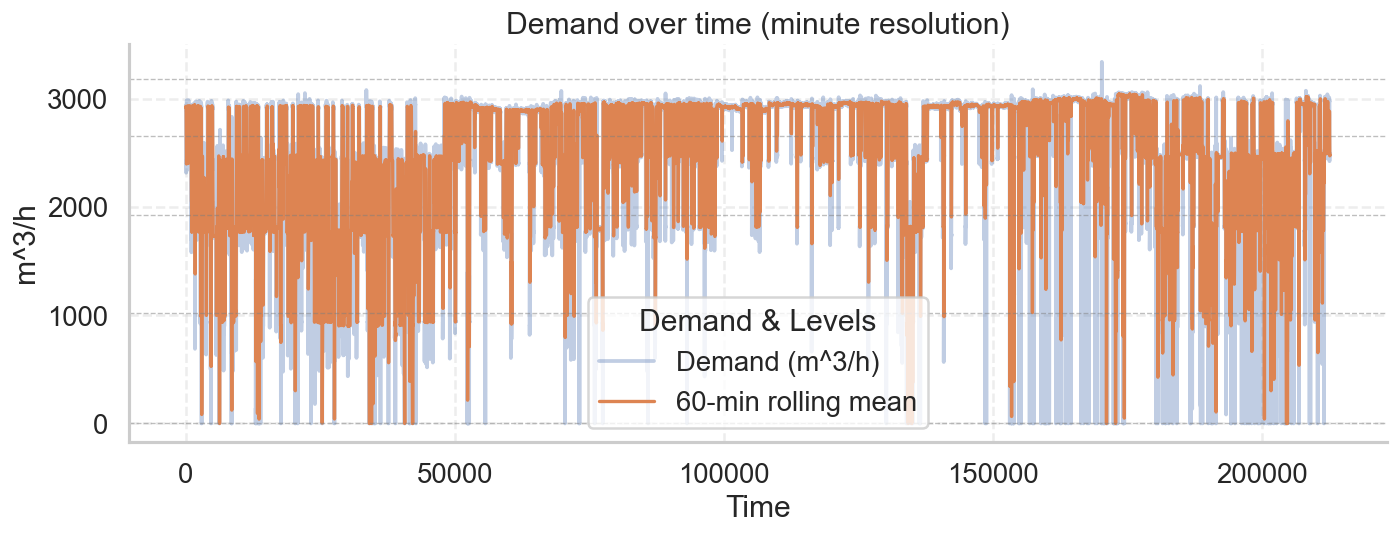

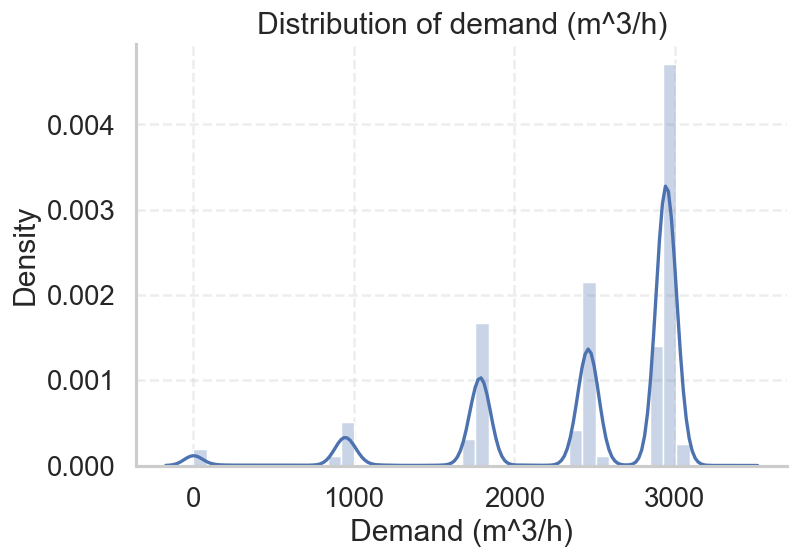

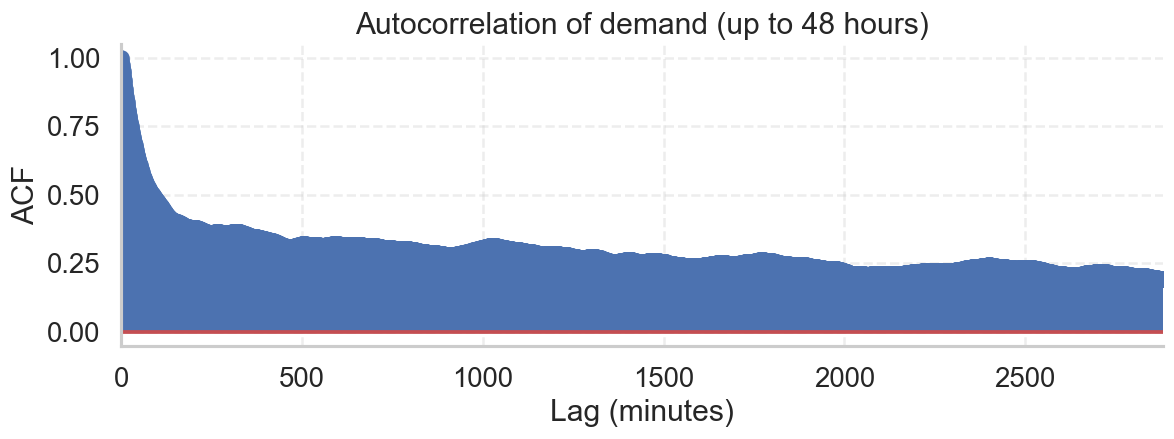

In [4]:
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

demand = pd.Series(demand_df["Demand"].to_numpy(dtype=float), name="Demand")
N = len(demand)

# Create a time index if you have none; prefer an existing datetime column if present.
if ("Time" in demand_df.columns) and np.issubdtype(demand_df["Time"].dtype, np.datetime64):
    tindex = pd.to_datetime(demand_df["Time"])
elif ("timestamp" in demand_df.columns) and np.issubdtype(demand_df["timestamp"].dtype, np.datetime64):
    tindex = pd.to_datetime(demand_df["timestamp"])
else:
    # Minute-based index starting at 0
    tindex = pd.RangeIndex(start=0, stop=N, step=1, name="minute")

demand.index = tindex

# 60-min rolling mean to de-noise minute-level series
roll_win = 60
demand_roll = demand.rolling(roll_win, min_periods=1).mean()

# Basic stats table
demand_stats = pd.DataFrame({
    "mean_m3ph": [demand.mean()],
    "std_m3ph": [demand.std(ddof=1)],
    "min_m3ph": [demand.min()],
    "p10_m3ph": [np.percentile(demand, 10)],
    "p50_m3ph": [np.percentile(demand, 50)],
    "p90_m3ph": [np.percentile(demand, 90)],
    "max_m3ph": [demand.max()],
    "n_minutes": [N]
})
display(demand_stats.style.format("{:.1f}"))

# ---------- Demand time series with discrete levels  ----------
fig, ax = plt.subplots(figsize=(12, 4.8))
ax.plot(demand.index, demand.values, alpha=0.35, label="Demand (m^3/h)")
ax.plot(demand_roll.index, demand_roll.values, linewidth=2.0, label=f"{roll_win}-min rolling mean")

# Overlay discrete demand levels if demand_map is defined
try:
    levels_sorted = [v for _, v in sorted(demand_map.items())]
    for y in levels_sorted:
        ax.axhline(y, color="tab:gray", linestyle="--", linewidth=0.8, alpha=0.5)
    ax.legend(title="Demand & Levels")
except Exception:
    ax.legend()

ax.set_title("Demand over time (minute resolution)")
ax.set_ylabel("m^3/h")
ax.set_xlabel("Time")
ax.grid(True, linestyle="--", alpha=0.35)
fig.tight_layout()
plt.show()

# ---------- Demand distribution (hist + KDE) ----------
fig, ax = plt.subplots(figsize=(7, 5))
sns.histplot(demand, bins=40, stat="density", alpha=0.3, ax=ax)
sns.kdeplot(demand, linewidth=2, ax=ax)
ax.set_title("Distribution of demand (m^3/h)")
ax.set_xlabel("Demand (m^3/h)")
ax.set_ylabel("Density")
ax.grid(True, linestyle="--", alpha=0.35)
fig.tight_layout()
plt.show()


# ---------- Autocorrelation up to 48 hours ----------
max_lag = 48 * 60  # minutes
x = demand.values - demand.values.mean()
acf_full = np.correlate(x, x, mode="full")
acf = acf_full[acf_full.size // 2 : acf_full.size // 2 + max_lag + 1]
acf = acf / acf[0] if acf[0] != 0 else acf

fig, ax = plt.subplots(figsize=(10, 4))
ax.stem(np.arange(len(acf)), acf)
ax.set_xlim(0, max_lag)
ax.set_title("Autocorrelation of demand (up to 48 hours)")
ax.set_xlabel("Lag (minutes)")
ax.set_ylabel("ACF")
ax.grid(True, linestyle="--", alpha=0.35)
fig.tight_layout()
plt.show()


## Proportional control heuristic model

At each minute the controller chooses discrete pump counts at each station using a simple, bottom-up proportional rule (no integral/derivative, no forecasting):


1. **Form targets (bottom-up proportional term).** Starting from the outlet demand, walk upstream. For station *i*, set

   $$
   \text{target}_i=\text{downstream\_need}+k_p\cdot(\text{target\_level}-\text{level}_{i+1})\cdot\frac{\text{reservoir\_capacity}}{\Delta t},
   $$

   where $\text{level}_{i+1}$ is the downstream reservoir level (fraction), $\Delta t=1$ minute, and the nominal target level is **60%**.


2. **Safety mask (hard bounds 30–90%).** Before choosing, simulate one minute ahead for each candidate action and discards any that would drive reservoirs R-2…R-5 outside **30–90%** (optionally with a safety margin e.g., 32-88%). If none are safe, select the least-bad option. The upstream reservoir (e.g., the first reservoir) is simulated but not constrained by 30–90%.


3. **Selection among safe candidates (lexicographic).**

   * **First:** **minimise step switches** (prefer staying at previous pump counts).
   * **Then:** among ties, **minimise failures to meet flow demands** $\sum_i(\text{flow}_i-\text{target}_i)^2$.
     Note: there is no numeric switching penalty added to a scalar objective; “switch aversion” is implemented as the first tie-break.


4. **Apply & update.** Apply the chosen counts, then update reservoir volumes (new = old + inflows − outflows; flows converted from m^3/h to per-minute volumes). **Energy** for the step is the sum of station powers × one minute.


**Discrete regimes.** Pump counts are integers from the regime tables; flows and power come directly from those mappings.

**Aim & limitations.** Meet demand, respect reservoir bounds, and avoid unnecessary switching. The policy is *myopic* (i.e., no look-ahead), so small steady offsets can persist when the nearest discrete regime still over- or under-delivers; the reservoir buffer, however, might absorb these small errors.



Heuristic total energy: 1,067,807.55 kWh
Heuristic total switches (all stations): 155
Heuristic min levels (R-2..R-5): [0.32  0.32  0.322 0.32 ]
Heuristic max levels (R-2..R-5): [0.88 0.88 0.88 0.88]
Violations flagged: False


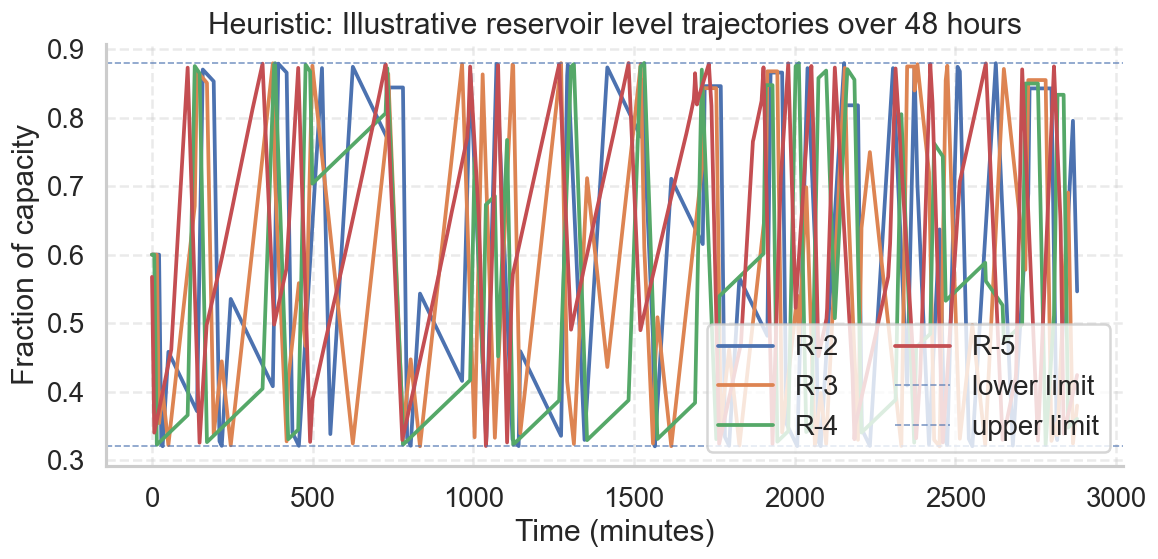

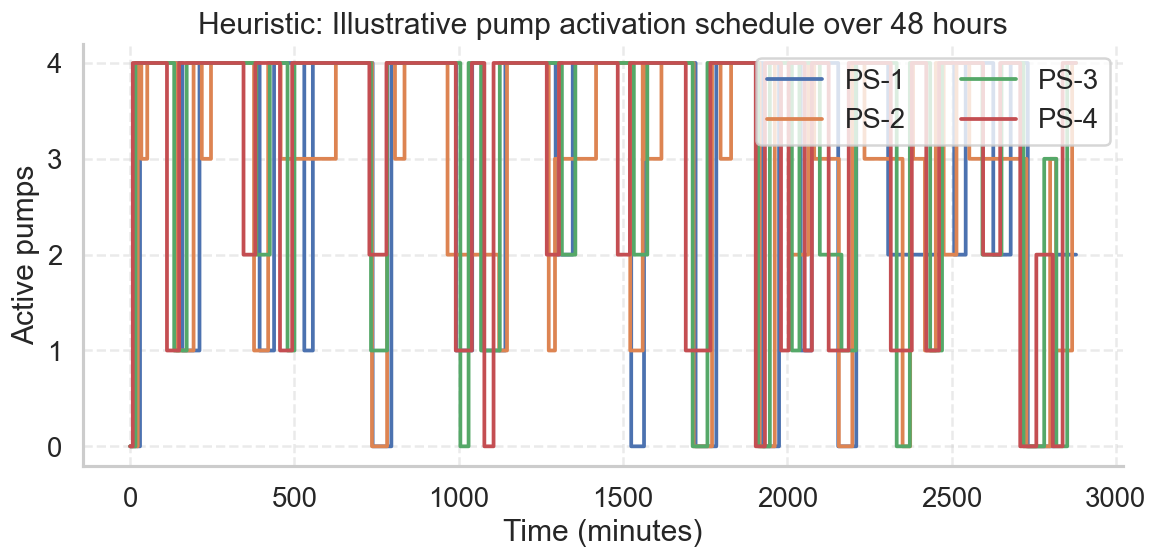

In [7]:
# -- Typical-behaviour demo ---

# Prepare regimes (sorted once)
regimes = prepare_regimes(regimes_list)

# Safety limits consistent with the rest of the analysis
lower_safe, upper_safe = 0.32, 0.88


# Run the heuristic controller
result = None

pump_history, energy_history, levels_history, info_h = heuristic_controller_safe(
    demand_series=demand_segment,
    regimes=regimes,
    tank_capacity=1500.0,
    lower_limit=lower_safe,
    upper_limit=upper_safe,
    target_fraction=0.6,
    proportional_gain=0.05,
    switching_penalty=100.0,  # not used in lexicographic tie-break, but kept for compatibility
    safety_margin=0.0
)


# Metrics
heuristic_switches = compute_switch_count(pump_history)

total_energy_heuristic = float(sum(energy_history))

# Levels: convert to array and drop any leading reservoir/time column if present
levels_raw = np.asarray(levels_history, dtype=float)
if "to_levels_array" in globals():
    levels_array = to_levels_array(levels_history)
else:
    levels_array = levels_raw[:, 1:] if levels_raw.ndim == 2 and levels_raw.shape[1] >= 5 else levels_raw

min_levels = levels_array.min(axis=0)
max_levels = levels_array.max(axis=0)

print(f"Heuristic total energy: {total_energy_heuristic:,.2f} kWh")
print(f"Heuristic total switches (all stations): {heuristic_switches}")
print(f"Heuristic min levels (R-2..R-5): {np.array2string(min_levels, precision=3)}")
print(f"Heuristic max levels (R-2..R-5): {np.array2string(max_levels, precision=3)}")
if isinstance(info_h, dict) and "had_violation" in info_h:
    print(f"Violations flagged: {info_h['had_violation']}")

# Plots — reservoir levels with safety lines
plt.figure(figsize=(10, 5))
for i in range(levels_array.shape[1]):
    plt.plot(levels_array[:, i], label=f"R-{i+2}")
plt.axhline(lower_safe, linestyle="--", linewidth=1, label="lower limit", alpha=0.7)
plt.axhline(upper_safe, linestyle="--", linewidth=1, label="upper limit", alpha=0.7)
plt.title("Heuristic: Illustrative reservoir level trajectories over 48 hours")
plt.xlabel("Time (minutes)")
plt.ylabel("Fraction of capacity")
plt.legend(loc="lower right", ncol=2)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Plots — pump schedule per station
pump_array = np.asarray(pump_history, dtype=int)
plt.figure(figsize=(10, 5))
for i in range(pump_array.shape[1]):
    plt.step(range(len(pump_array)), pump_array[:, i], where="post", label=f"PS-{i+1}")
plt.title("Heuristic: Illustrative pump activation schedule over 48 hours")
plt.xlabel("Time (minutes)")
plt.ylabel("Active pumps")
plt.yticks([0, 1, 2, 3, 4])
plt.legend(loc="upper right", ncol=2)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()



## Reinforcement Learning (RL) control model

I pose pump scheduling as a reinforcement-learning problem and use a **tabular Q-learning** agent with a coarse state space for tractability.

* **State.** A memoryless (Markov) encoding of the current system:

  * **Reservoir levels R-2…R-5** discretised with edges \[0.4, 0.6, 0.8] → bins: <40 %, 40–60 %, 60–80 %, >80 %.
  * **Demand** mapped to the nearest discrete level from the provided `demand_map`.
  * The discretiser encodes these into a single integer state via a mixed-radix encoding.

* **Actions.** A joint vector of pump counts for the four stations, each in {0,1,2,3,4}, yielding 5^4 = 625 discrete actions. Flows and power for each action come from the regimes tables.

* **Learning.** Tabular Q-learning with greedy exploration in training and greedy choice at evaluation:

  $$
  Q(s,a)\leftarrow Q(s,a)+\alpha\big[r+\gamma\max_{a'}Q(s',a')-Q(s,a)\big].
  $$

  Parameters used: $\alpha=0.1$, $\gamma=0.95$, $\epsilon=0.2$ (train), $\epsilon=0$ (eval).

* **Reward (per minute).** A negative cost.

  * **Unmet demand penalty** proportional to shortfall at the outlet.
  * **Level centring term** penalising the *absolute* deviation of each reservoir from the 60 % target.
  * **Switch penalty** when the joint action changes (tunable $sp_{\text{rl}}$).
  * **Violation penalty**: a very large penalty if any controlled reservoir is outside bounds.

* **Safety layer (one-step mask).** Before executing an action, it simulates one minute ahead and, if any reservoir would breach limits, adjust only the offending station’s pump count up/down until projected levels lie within the safe band. I apply the same limits in training and evaluation (spec: 30–90%, optionally tightened to 0.32–0.88 for safety margin).

* **Environment.** The same simulator used by the heuristic: per-minute updates `new = old + inflows − outflows` (flows in m^3/h → per-minute volumes), energy = ∑power × Δt.

* **Training & evaluation protocol.** For each outer fold, train on the fold’s training window for a small number of episodes, then evaluate on the 48-hour test window. Hyperparameters (e.g., switching/unmet penalties) are selected on inner validation; the same safety mask/limits are used in train and test.

* **Scope & limitations.** Coarse discretisation and a tabular Q-table make the approach tractable but approximate. The learned policy is reactive (i.e., does not provide explicit forecasting).


RL total energy: 939,037.81 kWh
RL total switches (all stations): 3087
RL min levels (R-2..R-5): [0.319 0.32  0.32  0.32 ]
RL max levels (R-2..R-5): [0.88  0.877 0.879 0.878]
Violations flagged: False


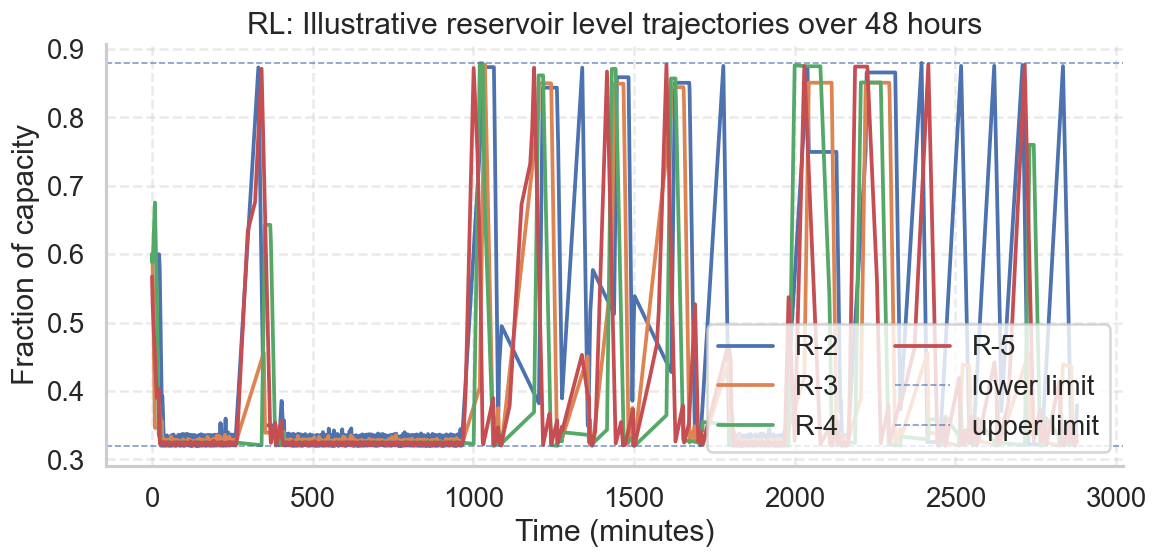

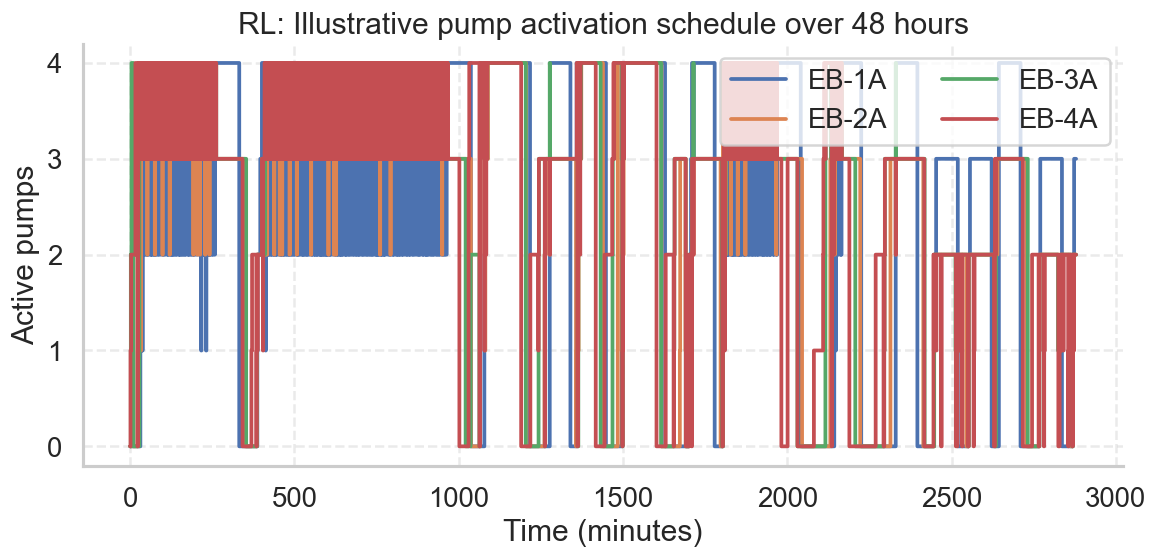

In [8]:
# -- Typical-behaviour demo ---

# Discretiser 
level_edges = [0.4, 0.6, 0.8]
state_discretiser = FullStateDiscretiser(
    level_bins=level_edges, demand_map=demand_map, n_tanks=4
)

# Regimes (sorted once)
regimes_obj = prepare_regimes(regimes_list)

# Agent & hyperparameters
action_options = [0, 1, 2, 3, 4]
agent = FullQLearningAgent(
    n_states=state_discretiser.n_states,
    pump_options=action_options,
    alpha=0.1,
    gamma=0.95,
    epsilon=0.2  # exploration
)

sp_rl = 10.0           #  tuned switch penalty in training
unmet_pen = 1.0        #  tuned unmet-demand penalty in training
energy_pen = 0.0       # savings come from behaviour
viol_pen = 1_000_000.0 # make violations effectively forbidden in training
lower_safe, upper_safe = 0.32, 0.88

# Choose a short training slice and a 48h test slice
train_minutes = 12 * 60
test_minutes  = 48 * 60
demand_np = demand_df["Demand"].to_numpy(dtype=float)
demand_train = demand_np[:train_minutes].tolist()
demand_test  = demand_np[train_minutes : train_minutes + test_minutes].tolist()

# Train 
full_train_agent(
    agent=agent,
    regimes=regimes_obj,
    demand_series=demand_train,
    discretiser=state_discretiser,
    episodes=10,
    target_fraction=0.6,
    switching_penalty=sp_rl,
    energy_penalty=energy_pen,
    unmet_penalty=unmet_pen,
    violation_penalty=viol_pen,
    lower_limit=lower_safe,
    upper_limit=upper_safe
)


# Greedy evaluation (epsilon=0) using the masked evaluator's actual signature
agent.epsilon = 0.0
actions, energy_rl, levels_rl, info_rl = full_evaluate_agent_masked(
    agent=agent,
    regimes=regimes_obj,
    demand_series=demand_test,
    discretiser=state_discretiser,
    lower_limit=lower_safe,
    upper_limit=upper_safe,
    q_tie_tol=1e-3
)

# Metrics: switches across all stations; min/max levels per reservoir
action_array = np.asarray(actions, dtype=int)               # shape [T, 4]
switches_rl = int(np.sum(action_array[1:] != action_array[:-1]))  # per-station changes

levels_array_rl = np.asarray(levels_rl, dtype=float)        # R-2..R-5
min_levels_rl = levels_array_rl.min(axis=0)
max_levels_rl = levels_array_rl.max(axis=0)

print(f"RL total energy: {energy_rl:,.2f} kWh")
print(f"RL total switches (all stations): {switches_rl}")
print(f"RL min levels (R-2..R-5): {np.array2string(min_levels_rl, precision=3)}")
print(f"RL max levels (R-2..R-5): {np.array2string(max_levels_rl, precision=3)}")
if isinstance(info_rl, dict) and "had_violation" in info_rl:
    print(f"Violations flagged: {info_rl['had_violation']}")

# Plot reservoir levels with safety lines
plt.figure(figsize=(10, 5))
for i in range(levels_array_rl.shape[1]):
    plt.plot(levels_array_rl[:, i], label=f"R-{i+2}")
plt.axhline(lower_safe, linestyle="--", linewidth=1, label="lower limit", alpha=0.7)
plt.axhline(upper_safe, linestyle="--", linewidth=1, label="upper limit", alpha=0.7)
plt.title("RL: Illustrative reservoir level trajectories over 48 hours")
plt.xlabel("Time (minutes)")
plt.ylabel("Fraction of capacity")
plt.legend(loc="lower right", ncol=2)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Plots pump schedule per station
plt.figure(figsize=(10, 5))
for i in range(action_array.shape[1]):
    plt.step(range(len(action_array)), action_array[:, i], where="post", label=f"EB-{i+1}A")
plt.title("RL: Illustrative pump activation schedule over 48 hours")
plt.xlabel("Time (minutes)")
plt.ylabel("Active pumps")
plt.yticks([0, 1, 2, 3, 4])
plt.legend(loc="upper right", ncol=2)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()



## Model selection with nested time-series CV and a global hyperparameter pass

**Goal.** Pick robust hyperparameters for each controller avoiding test leakage, then choose a single deployable setting per model.

### Outer loop: rolling time-series evaluation

* **Splits.** Fixed-window, chronological folds: 24 h train → 48 h test (5 folds), using `TimeSeriesSplit` with `max_train_size=train_len`, `test_size=test_len`.
* **Heuristic:** **Not trained.** For any hyperparameter pair $(k_p,\;\text{switch preference})$ it is simply **applied** on the window.
* **RL:** Trained per fold on the outer train window (tabular Q-learning, limited episodes), then evaluated greedily on the test window (set $\epsilon=0$).
* **Safety & bounds.** The same one-step safety mask and limits (e.g., 30–90% or tightened 0.32–0.88) are used in train/validation/test.

### Inner loop: hyperparameter selection (inside each outer train window)

* **Splitting.** Time-ordered validation (multi-split `TimeSeriesSplit` or last-quarter hold-out).
* **Validation objective.**

  $$
  \text{cost}=\text{energy}+\lambda\times\text{switches}
  $$

  where *switches* are counted across all stations; any *violation* or *unmet demand* is treated as a hard constraint (i.e., very large penalty → effectively reject).
* **Heuristic:** No fitting—**evaluate** each candidate $(k_p,\;\text{switch preference})$ on inner folds; pick the lowest mean cost.
* **RL:** For each candidate $(\text{switch penalty},\;\text{unmet penalty})$, train on inner-train, evaluate on inner-val, and average over multiple seeds to reduce stochasticity; pick the **lowest seed-averaged mean cost**.

The selected inner-loop hyperparameters are then used to produce **outer-fold test metrics** (energy, switches, constraint flags), giving an unbiased estimate per fold.

### Global hyperparameter pass (single deployable setting)

* For deployment, I also pick a **single** setting per model:

  1. For each candidate, average its inner-validation cost across all outer folds (still no test leakage).
  2. Select the global best per model.
  3. Heuristic: apply that fixed setting to each outer **test** window.
     **RL:** re-initialize and retrain per fold with that fixed setting; average test results over several seeds for stability.
* Finally, aggregate per-fold test metrics and run paired comparisons (e.g., ΔEnergy, ΔSwitches) between RL and the heuristic.

**Rationale** Nested CV ensures hyperparameters never see test data. The global pass yields a single deployable configuration per model. Treating the heuristic as *evaluate-only* and the RL as *train-then-test per fold* reflects their nature and keeps the comparison fair.


In [6]:
def run_nested_eval_with_sklearn(
    demand_df,
    regimes_list: list[dict],
    train_len: int = 24 * 60,
    test_len: int = 48 * 60,
    n_splits: int = 5,
    gap: int = 0,
    # hyperparameter grids
    heuristic_prop_gains: list[float] = [0.02, 0.05],
    heuristic_switch_penalties: list[float] = [50.0, 100.0],
    rl_switch_penalties: list[float] = [3.0, 5.0, 10.0, 20.0, 50.0, 100.0],
    rl_unmet_penalties: list[float] = [1.0, 5.0],
    # inner splitting
    use_inner_cv: bool = True,
    n_inner_splits: int = 3,
    val_fraction: float = 0.25,
    # RL stability
    rl_inner_seeds: int = 3,
    rl_seed_base: int = 1337,
    rl_inner_episodes: int = 5,
    rl_outer_episodes: int = 8,
    # safety mask 
    safety_lower: float = 0.3,
    safety_upper: float = 0.9,
    # evaluation stability
    q_tie_tol: float = 1e-3,
    # parallelism
    n_jobs: int = -1,
    verbose: bool = True
):
    """Nested CV with consistent safety limits. These bounds are used for both training and evaluation.

    Pass `safety_lower` and `safety_upper` to align inner-CV selection with outer-test behavior and
    to prevent the train/eval mismatch that causes surprising violations in multi-seed global evals.
    """
    demand = demand_df["Demand"].to_numpy()
    N = len(demand)

    heur_test_metrics: list[tuple[float, int]] = []
    rl_test_metrics: list[tuple[float, int]] = []
    heur_val_costs: dict[tuple[float, float], list[tuple[int, int, float, float]]] = {}
    rl_val_costs: dict[tuple[float, float], list[tuple[int, int, float, float]]] = {}

    for fold_id, (train_idx, test_idx) in enumerate(outer_time_series_splits(
        n_samples=N, train_len=train_len, test_len=test_len, n_splits=n_splits, gap=gap
    ), start=1):
        regimes_obj = prepare_regimes(regimes_list)
        inner_splits = (list(inner_time_series_splits(train_idx, val_fraction, n_inner_splits, 0))
                        if use_inner_cv else [last_quarter_holdout(train_idx)])

        # ---------- Heuristic inner selection ----------
        best_h_params = None
        best_h_summary = (10**9, 10**9, float("inf"), float("inf"))

        for pg in heuristic_prop_gains:
            for sp in heuristic_switch_penalties:
                inner_tuples: list[tuple[int, int, int, float]] = []
                for tr_idx, va_idx in inner_splits:
                    val_series = demand[va_idx].tolist()
                    pump_hist, energy_hist, _, info = heuristic_with_info(
                        demand_series=val_series,
                        regimes=regimes_obj,
                        tank_capacity=1500.0,
                        proportional_gain=pg,
                        switching_penalty=sp,
                        lower_limit=safety_lower,
                        upper_limit=safety_upper
                    )
                    inner_tuples.append(
                        lexicographic_cost(
                            energy=sum(energy_hist),
                            switches=count_switches_schedule(pump_hist),
                            had_violation=bool(info.get("had_violation", False)),
                            had_unmet=bool(info.get("had_unmet", False))
                        )
                    )
                cand_summary = summarize_lexicographic(inner_tuples)
                heur_val_costs.setdefault((pg, sp), []).append(cand_summary)
                if cand_summary < best_h_summary:
                    best_h_summary, best_h_params = cand_summary, (pg, sp)

        # Heuristic outer test
        assert best_h_params is not None
        test_series = demand[test_idx].tolist()
        pg_best, sp_best = best_h_params
        pump_hist, energy_hist, _, info_h = heuristic_with_info(
            demand_series=test_series,
            regimes=regimes_obj,
            tank_capacity=1500.0,
            proportional_gain=pg_best,
            switching_penalty=sp_best,
            lower_limit=safety_lower,
            upper_limit=safety_upper
        )
        heur_test_metrics.append((float(sum(energy_hist)), int(count_switches_schedule(pump_hist))))
        h_violation = bool(info_h.get("had_violation", False))
        h_unmet = bool(info_h.get("had_unmet", False))

        # ---------- RL inner selection (parallel over seeds) ----------
        best_rl_params = None
        best_rl_summary = (10**9, 10**9, float("inf"), float("inf"))

        def _eval_one_seed(seed: int, train_series: list[float], val_series: list[float], sp_rl: float, up: float):
            with temp_seed(seed):
                discretiser = FullStateDiscretiser(level_bins=[0.4, 0.6, 0.8], demand_map=demand_map, n_tanks=4)
                agent = FullQLearningAgent(
                    n_states=discretiser.n_states,
                    pump_options=[0, 1, 2, 3, 4],
                    alpha=0.1, gamma=0.95, epsilon=0.2
                )
                full_train_agent(
                    agent=agent,
                    regimes=regimes_obj,
                    demand_series=train_series,
                    discretiser=discretiser,
                    episodes=rl_inner_episodes,
                    target_fraction=0.6,
                    switching_penalty=sp_rl,
                    energy_penalty=0.001,
                    unmet_penalty=up,
                    violation_penalty=50.0,
                    lower_limit=safety_lower,
                    upper_limit=safety_upper
                )
                actions_val, energy_val, _, info = rl_evaluate_with_info(
                    agent=agent,
                    regimes=regimes_obj,
                    demand_series=val_series,
                    discretiser=discretiser,
                    target_fraction=0.6,
                    switching_penalty=sp_rl,
                    energy_penalty=0.001,
                    unmet_penalty=up,
                    violation_penalty=50.0,
                    lower_limit=safety_lower,
                    upper_limit=safety_upper,
                    q_tie_tol=q_tie_tol
                )
                return lexicographic_cost(
                    energy=energy_val,
                    switches=count_switches_actions(actions_val),
                    had_violation=bool(info.get("had_violation", False)),
                    had_unmet=bool(info.get("had_unmet", False))
                )

        for sp_rl in rl_switch_penalties:
            for up in rl_unmet_penalties:
                inner_summaries: list[tuple[int, int, float, float]] = []
                for tr_idx, va_idx in inner_splits:
                    train_series = demand[tr_idx].tolist()
                    val_series = demand[va_idx].tolist()
                    seeds = [rl_seed_base + s for s in range(rl_inner_seeds)]
                    if Parallel is not None:
                        seed_tuples = Parallel(n_jobs=n_jobs, prefer="threads")(
                            delayed(_eval_one_seed)(s, train_series, val_series, sp_rl, up) for s in seeds
                        )
                    else:
                        seed_tuples = [_eval_one_seed(s, train_series, val_series, sp_rl, up) for s in seeds]
                    inner_summaries.append(summarize_lexicographic(seed_tuples))

                cand_summary = summarize_lexicographic(inner_summaries)
                rl_val_costs.setdefault((sp_rl, up), []).append(cand_summary)
                if cand_summary < best_rl_summary:
                    best_rl_summary, best_rl_params = cand_summary, (sp_rl, up)

        # RL outer test (single run here; multi-seed is done in global evaluator)
        assert best_rl_params is not None
        sp_rl_best, up_best = best_rl_params
        discretiser = FullStateDiscretiser(level_bins=[0.4, 0.6, 0.8], demand_map=demand_map, n_tanks=4)
        agent = FullQLearningAgent(n_states=discretiser.n_states, pump_options=[0, 1, 2, 3, 4], alpha=0.1, gamma=0.95, epsilon=0.2)
        full_train_series = demand[train_idx].tolist()
        full_train_agent(
            agent=agent,
            regimes=regimes_obj,
            demand_series=full_train_series,
            discretiser=discretiser,
            episodes=rl_outer_episodes,
            target_fraction=0.6,
            switching_penalty=sp_rl_best,
            energy_penalty=0.001,
            unmet_penalty=up_best,
            violation_penalty=50.0,
            lower_limit=safety_lower,
            upper_limit=safety_upper
        )
        actions_test, energy_test, _, info_r = rl_evaluate_with_info(
            agent=agent,
            regimes=regimes_obj,
            demand_series=test_series,
            discretiser=discretiser,
            target_fraction=0.6,
            switching_penalty=sp_rl_best,
            energy_penalty=0.001,
            unmet_penalty=up_best,
            violation_penalty=50.0,
            lower_limit=safety_lower,
            upper_limit=safety_upper,
            q_tie_tol=q_tie_tol
        )
        rl_test_metrics.append((float(energy_test), int(count_switches_actions(actions_test))))

        if verbose:
            print(
                f"[Outer {fold_id}] Heur val: viol={best_h_summary[0]}, unmet={best_h_summary[1]}, "
                f"sw={best_h_summary[2]:.1f}, E={best_h_summary[3]:.2f} | "
                f"test: E={sum(energy_hist):.2f} kWh, S={count_switches_schedule(pump_hist)}, "
                f"Viol={'Y' if h_violation else 'N'}, Unmet={'Y' if h_unmet else 'N'}"
            )
            print(
                f"[Outer {fold_id}] RL   val: viol={best_rl_summary[0]}, unmet={best_rl_summary[1]}, "
                f"sw={best_rl_summary[2]:.1f}, E={best_rl_summary[3]:.2f} | "
                f"test: E={energy_test:.2f} kWh, S={count_switches_actions(actions_test)}, "
                f"Viol={'Y' if bool(info_r.get('had_violation', False)) else 'N'}, "
                f"Unmet={'Y' if bool(info_r.get('had_unmet', False)) else 'N'}"
            )

    return heur_test_metrics, rl_test_metrics, heur_val_costs, rl_val_costs


def evaluate_global_params_on_outer_tests(
    demand_df,
    regimes_list: list[dict],
    heur_val_costs: dict[tuple[float, float], list[tuple[int, int, float, float]]],
    rl_val_costs: dict[tuple[float, float], list[tuple[int, int, float, float]]],
    train_len: int = 24 * 60,
    test_len: int = 48 * 60,
    n_splits: int = 5,
    gap: int = 0,
    rl_test_seeds: int = 7,
    rl_seed_base: int = 2025,
    rl_outer_episodes: int = 12,
    rl_alpha: float = 0.1,
    rl_gamma: float = 0.95,
    rl_epsilon_train: float = 0.2,
    rl_eval_greedy: bool = True,
    # safety mask 
    safety_lower: float = 0.3,
    safety_upper: float = 0.9,
    # evaluation stability
    q_tie_tol: float = 1e-3,
    # parallelism
    n_jobs: int = -1
) -> dict[str, Any]:
    """Evaluate globally best params with consistent safety limits across train and eval."""
    demand = demand_df["Demand"].to_numpy()

    best_heuristic_params, best_heuristic_summary = min(
        ((p, summarize_lexicographic(c)) for p, c in heur_val_costs.items()), key=lambda t: t[1]
    )
    best_rl_params, best_rl_summary = min(
        ((p, summarize_lexicographic(c)) for p, c in rl_val_costs.items()), key=lambda t: t[1]
    )
    print(
        "Global best heuristic (by validation): "
        f"pg={best_heuristic_params[0]}, sp={best_heuristic_params[1]} "
        f"(val summary: viol={best_heuristic_summary[0]}, unmet={best_heuristic_summary[1]}, "
        f"sw={best_heuristic_summary[2]:.1f}, E={best_heuristic_summary[3]:.2f})"
    )
    print(
        "Global best RL (by validation): "
        f"sp_rl={best_rl_params[0]}, unmet={best_rl_params[1]} "
        f"(val summary: viol={best_rl_summary[0]}, unmet={best_rl_summary[1]}, "
        f"sw={best_rl_summary[2]:.1f}, E={best_rl_summary[3]:.2f})"
    )

    heur_energy_per_fold, heur_switches_per_fold = [], []
    heur_violations_per_fold, heur_unmet_per_fold = [], []
    rl_energy_mean_per_fold, rl_switches_mean_per_fold = [], []
    rl_violation_rate_per_fold, rl_unmet_rate_per_fold = [], []

    for fold_id, (train_idx, test_idx) in enumerate(outer_time_series_splits(
        n_samples=len(demand), train_len=train_len, test_len=test_len, n_splits=n_splits, gap=gap
    ), start=1):
        regimes_obj = prepare_regimes(regimes_list)
        test_series = demand[test_idx].tolist()
        train_series = demand[train_idx].tolist()

        # Heuristic
        pg_best, sp_best = best_heuristic_params
        pump_hist, energy_hist, _, info_h = heuristic_with_info(
            demand_series=test_series,
            regimes=regimes_obj,
            tank_capacity=1500.0,
            proportional_gain=pg_best,
            switching_penalty=sp_best,
            lower_limit=safety_lower,
            upper_limit=safety_upper
        )
        heur_energy = float(sum(energy_hist))
        heur_switches = int(count_switches_schedule(pump_hist))
        heur_energy_per_fold.append(heur_energy)
        heur_switches_per_fold.append(heur_switches)
        heur_violations_per_fold.append(bool(info_h.get("had_violation", False)))
        heur_unmet_per_fold.append(bool(info_h.get("had_unmet", False)))

        # RL: parallel per seed
        sp_rl_best, up_best = best_rl_params
        seeds = [rl_seed_base + s for s in range(rl_test_seeds)]

        def _train_and_test(seed: int) -> tuple[float, int, bool, bool]:
            with temp_seed(seed):
                discretiser = FullStateDiscretiser(level_bins=[0.4, 0.6, 0.8], demand_map=demand_map, n_tanks=4)
                agent = FullQLearningAgent(
                    n_states=discretiser.n_states,
                    pump_options=[0, 1, 2, 3, 4],
                    alpha=rl_alpha, gamma=rl_gamma, epsilon=rl_epsilon_train
                )
                full_train_agent(
                    agent=agent,
                    regimes=regimes_obj,
                    demand_series=train_series,
                    discretiser=discretiser,
                    episodes=rl_outer_episodes,
                    target_fraction=0.6,
                    switching_penalty=sp_rl_best,
                    energy_penalty=0.0,
                    unmet_penalty=up_best,
                    violation_penalty=1_000_000.0,
                    lower_limit=safety_lower,
                    upper_limit=safety_upper
                )
                if rl_eval_greedy and hasattr(agent, "epsilon"):
                    try:
                        agent.epsilon = 0.0
                    except Exception:
                        pass
                actions_eval, energy_eval, _, info_r = rl_evaluate_with_info(
                    agent=agent,
                    regimes=regimes_obj,
                    demand_series=test_series,
                    discretiser=discretiser,
                    target_fraction=0.6,
                    switching_penalty=sp_rl_best,
                    energy_penalty=0.0,
                    unmet_penalty=up_best,
                    violation_penalty=1_000_000.0,
                    lower_limit=safety_lower,
                    upper_limit=safety_upper,
                    q_tie_tol=q_tie_tol
                )
                return (
                    float(energy_eval),
                    int(count_switches_actions(actions_eval)),
                    bool(info_r.get("had_violation", False)),
                    bool(info_r.get("had_unmet", False))
                )

        if Parallel is not None:
            per_seed = Parallel(n_jobs=n_jobs, prefer="threads")(delayed(_train_and_test)(s) for s in seeds)
        else:
            per_seed = [_train_and_test(s) for s in seeds]

        seed_energies, seed_switches, seed_viol, seed_unmet = zip(*per_seed)
        rl_energy_mean_per_fold.append(float(np.mean(seed_energies)))
        rl_switches_mean_per_fold.append(float(np.mean(seed_switches)))
        rl_violation_rate_per_fold.append(float(np.mean(seed_viol)))
        rl_unmet_rate_per_fold.append(float(np.mean(seed_unmet)))

        print(
            f"Fold {fold_id}: "
            f"Heur E={heur_energy:.2f} kWh, S={heur_switches}, "
            f"Viol={'Y' if heur_violations_per_fold[-1] else 'N'}, "
            f"Unmet={'Y' if heur_unmet_per_fold[-1] else 'N'}; "
            f"RL E={np.mean(seed_energies):.2f} kWh, S={np.mean(seed_switches):.1f}, "
            f"ViolRate={np.mean(seed_viol):.2f}, UnmetRate={np.mean(seed_unmet):.2f} "
            f"(over {len(seeds)} seeds)"
        )

        # -------- Aggregated summaries --------
    heur_E = np.asarray(heur_energy_per_fold)
    heur_S = np.asarray(heur_switches_per_fold)
    heur_V = np.asarray(heur_violations_per_fold, dtype=float)
    heur_U = np.asarray(heur_unmet_per_fold, dtype=float)

    rl_E = np.asarray(rl_energy_mean_per_fold)
    rl_S = np.asarray(rl_switches_mean_per_fold)
    rl_V = np.asarray(rl_violation_rate_per_fold)
    rl_U = np.asarray(rl_unmet_rate_per_fold)

    print("\n=== Global params on outer test folds (masked, with unmet) ===")
    print(f"Heuristic energy: {heur_E.mean():.2f} ± {heur_E.std(ddof=1):.2f} kWh")
    print(f"Heuristic switches: {heur_S.mean():.1f} ± {heur_S.std(ddof=1):.1f}")
    print(f"Heuristic violation rate: {heur_V.mean():.2f}")
    print(f"Heuristic unmet rate: {heur_U.mean():.2f}")

    print(f"RL energy: {rl_E.mean():.2f} ± {rl_E.std(ddof=1):.2f} kWh")
    print(f"RL switches: {rl_S.mean():.1f} ± {rl_S.std(ddof=1):.1f}")
    print(f"RL violation rate: {rl_V.mean():.2f}")
    print(f"RL unmet rate: {rl_U.mean():.2f}")

    return {
        "best_heuristic_params": best_heuristic_params,
        "best_rl_params": best_rl_params,
        "heuristic": {
            "energy_per_fold": heur_energy_per_fold,
            "switches_per_fold": heur_switches_per_fold,
            "violation_per_fold": heur_violations_per_fold,
            "unmet_per_fold": heur_unmet_per_fold,
            "energy_mean": float(heur_E.mean()),
            "energy_sd": float(heur_E.std(ddof=1)) if len(heur_E) > 1 else 0.0,
            "switch_mean": float(heur_S.mean()),
            "switch_sd": float(heur_S.std(ddof=1)) if len(heur_S) > 1 else 0.0,
            "violation_rate_mean": float(heur_V.mean()),
            "unmet_rate_mean": float(heur_U.mean())
        },
        "rl": {
            "energy_mean_per_fold": rl_energy_mean_per_fold,
            "switch_mean_per_fold": rl_switches_mean_per_fold,
            "violation_rate_per_fold": rl_violation_rate_per_fold,
            "unmet_rate_per_fold": rl_unmet_rate_per_fold,
            "energy_mean": float(rl_E.mean()),
            "energy_sd": float(rl_E.std(ddof=1)) if len(rl_E) > 1 else 0.0,
            "switch_mean": float(rl_S.mean()),
            "switch_sd": float(rl_S.std(ddof=1)) if len(rl_S) > 1 else 0.0,
            "violation_rate_mean": float(rl_V.mean()),
            "unmet_rate_mean": float(rl_U.mean())
        }
    }


In [ ]:
# NOTE: CV takes a rather long time (~6h on a Macbook Pro - ARM)

SAFETY_LOWER = 0.32
SAFETY_UPPER = 0.88
run = False
if run:
    heur_test_metrics, rl_test_metrics, heur_val_costs, rl_val_costs = run_nested_eval_with_sklearn(
        demand_df=demand_df,
        regimes_list=regimes_list,
        use_inner_cv=True,
        n_inner_splits=3,
        rl_inner_seeds=5,
        rl_inner_episodes=8,
        rl_outer_episodes=12,
        safety_lower=SAFETY_LOWER,
        safety_upper=SAFETY_UPPER,
        q_tie_tol=1e-3,
        n_jobs=-1
    )

    results = evaluate_global_params_on_outer_tests(
        demand_df=demand_df,
        regimes_list=regimes_list,
        heur_val_costs=heur_val_costs,
        rl_val_costs=rl_val_costs,
        train_len=24*60,
        test_len=48*60,
        n_splits=5,
        rl_test_seeds=7,
        rl_seed_base=4242,
        rl_outer_episodes=12,
        rl_eval_greedy=True,
        safety_lower=SAFETY_LOWER,
        safety_upper=SAFETY_UPPER,
        q_tie_tol=1e-3,
        n_jobs=-1
    )
else:
    loaded = load_model_selection_summary("./artifacts/model_selection_summary.json")

    # Grab configs to recreate splits
    train_len  = loaded["data"]["train_len"]
    test_len   = loaded["data"]["test_len"]
    n_splits   = loaded["data"]["n_splits"]
    gap        = loaded["data"]["gap"]
    safety_lower = loaded["safety_limits"]["lower"]
    safety_upper = loaded["safety_limits"]["upper"]
    level_bins   = loaded["discretiser"]["level_bins"]

    # Grids and best params
    heuristic_prop_gains       = loaded["grids"]["heuristic_prop_gains"]
    heuristic_switch_penalties = loaded["grids"]["heuristic_switch_penalties"]
    rl_switch_penalties        = loaded["grids"]["rl_switch_penalties"]
    rl_unmet_penalties         = loaded["grids"]["rl_unmet_penalties"]

    best_heuristic_params = loaded["best_heuristic_params"]
    best_rl_params        = loaded["best_rl_params"]

    # Per-fold outer metrics (for plots)
    heur_test_metrics = loaded["heur_test_metrics"]  # [(energy, switches), ...]
    rl_test_metrics   = loaded["rl_test_metrics"]
    
    report = format_global_search_report(loaded)
    print(report)

Global best heuristic (by validation): pg=0.02, sp=50.0 (mean val cost=0.00)
Global best RL (by validation): sp_rl=10.0, unmet=1.0 (mean val cost=0.00)
Fold 1: Heur E=963,755.74 kWh, S=119, Viol=N, Unmet=N; RL E=956,967.35 kWh, S=2262.1, ViolRate=0.00, UnmetRate=0.00 (over 7 seeds)
Fold 2: Heur E=847,943.63 kWh, S=139, Viol=N, Unmet=N; RL E=835,889.75 kWh, S=2023.7, ViolRate=0.00, UnmetRate=0.00 (over 7 seeds)
Fold 3: Heur E=811,516.59 kWh, S=132, Viol=N, Unmet=N; RL E=801,478.34 kWh, S=595.1, ViolRate=0.00, UnmetRate=0.00 (over 7 seeds)
Fold 4: Heur E=1,172,628.46 kWh, S=90, Viol=N, Unmet=N; RL E=1,165,205.66 kWh, S=4960.3, ViolRate=0.00, UnmetRate=0.00 (over 7 seeds)
Fold 5: Heur E=945,267.19 kWh, S=118, Viol=N, Unmet=N; RL E=937,956.56 kWh, S=697.7, ViolRate=0.00, UnmetRate=0.00 (over 7 seeds)

=== Global params on outer test folds (masked, with unmet) ===
Heuristic energy: 948,222.32 ± 140,847.80 kWh
Heuristic switches: 119.6 ± 18.8
Heuristic violation rate: 0.00
Heuristic unmet ra

## Differences in policy

### How the two policies behave — and why RL uses less energy
* **Regime timelines.**
  The heuristic tends to have more streches where all stations operate at high regime. RL, instead, shows more OFF periods, shorter bursts at active steps, especially for station 3 and 4. Visually, RL has more black space” (pumps off) than the heuristic model.

* **Delivered − Demand (violin).**
  The heuristic’s violin is wide and multimodal with a heavy positive tail: it often sits in regimes that over-deliver by a fixed offset (those bulges align with discrete pump steps). RL’s violin is mostly centered closer to 0, with fewer large positive excursions and only a thin negative tail. In plain terms, RL is more aligned to the demand steps and avoids chronic over-pumping; brief under-delivery is buffered by the reservoirs (no unmet events overall).

* **Dwell-time distributions.**
  RL’s dwell plot shows more mass at OFF and shorter stays on adjacent steps, i.e., it opportunistically turns pumps off (or down) during short troughs instead of holding a high step “just in case”.

* **Transition matrices.**
  Heuristic matrices are dominated by the main diagonal: once a step is chosen, it tends to stick. RL exhibits richer off-diagonal activity, especially transitions to/from OFF and between adjacent step*. That pattern is exactly what you need to track a discretised demand process without sitting above it.

**Why this saves electricity (despite more switching):**

1. **Less time running pumps.** OFF periods and quick step-downs during dips mean fewer minutes drawing power.
2. **Less chronic over-delivery.** Avoiding those big positive “Delivered − Demand” offsets removes wasted flow that would otherwise cost energy.
3. **Targeted regime use.** By moving along adjacent steps (and into OFF) instead of cruising high, RL concentrates throughput into more favorable operating moments and avoids inefficient overrun.

Both policies meet constraints (0 violations, 0 unmet). So the difference is policy style: the heuristic trades energy for stability/low switching, while RL trades more switching for tighter demand tracking and less over-pumping, which shows up as the observed energy reduction.


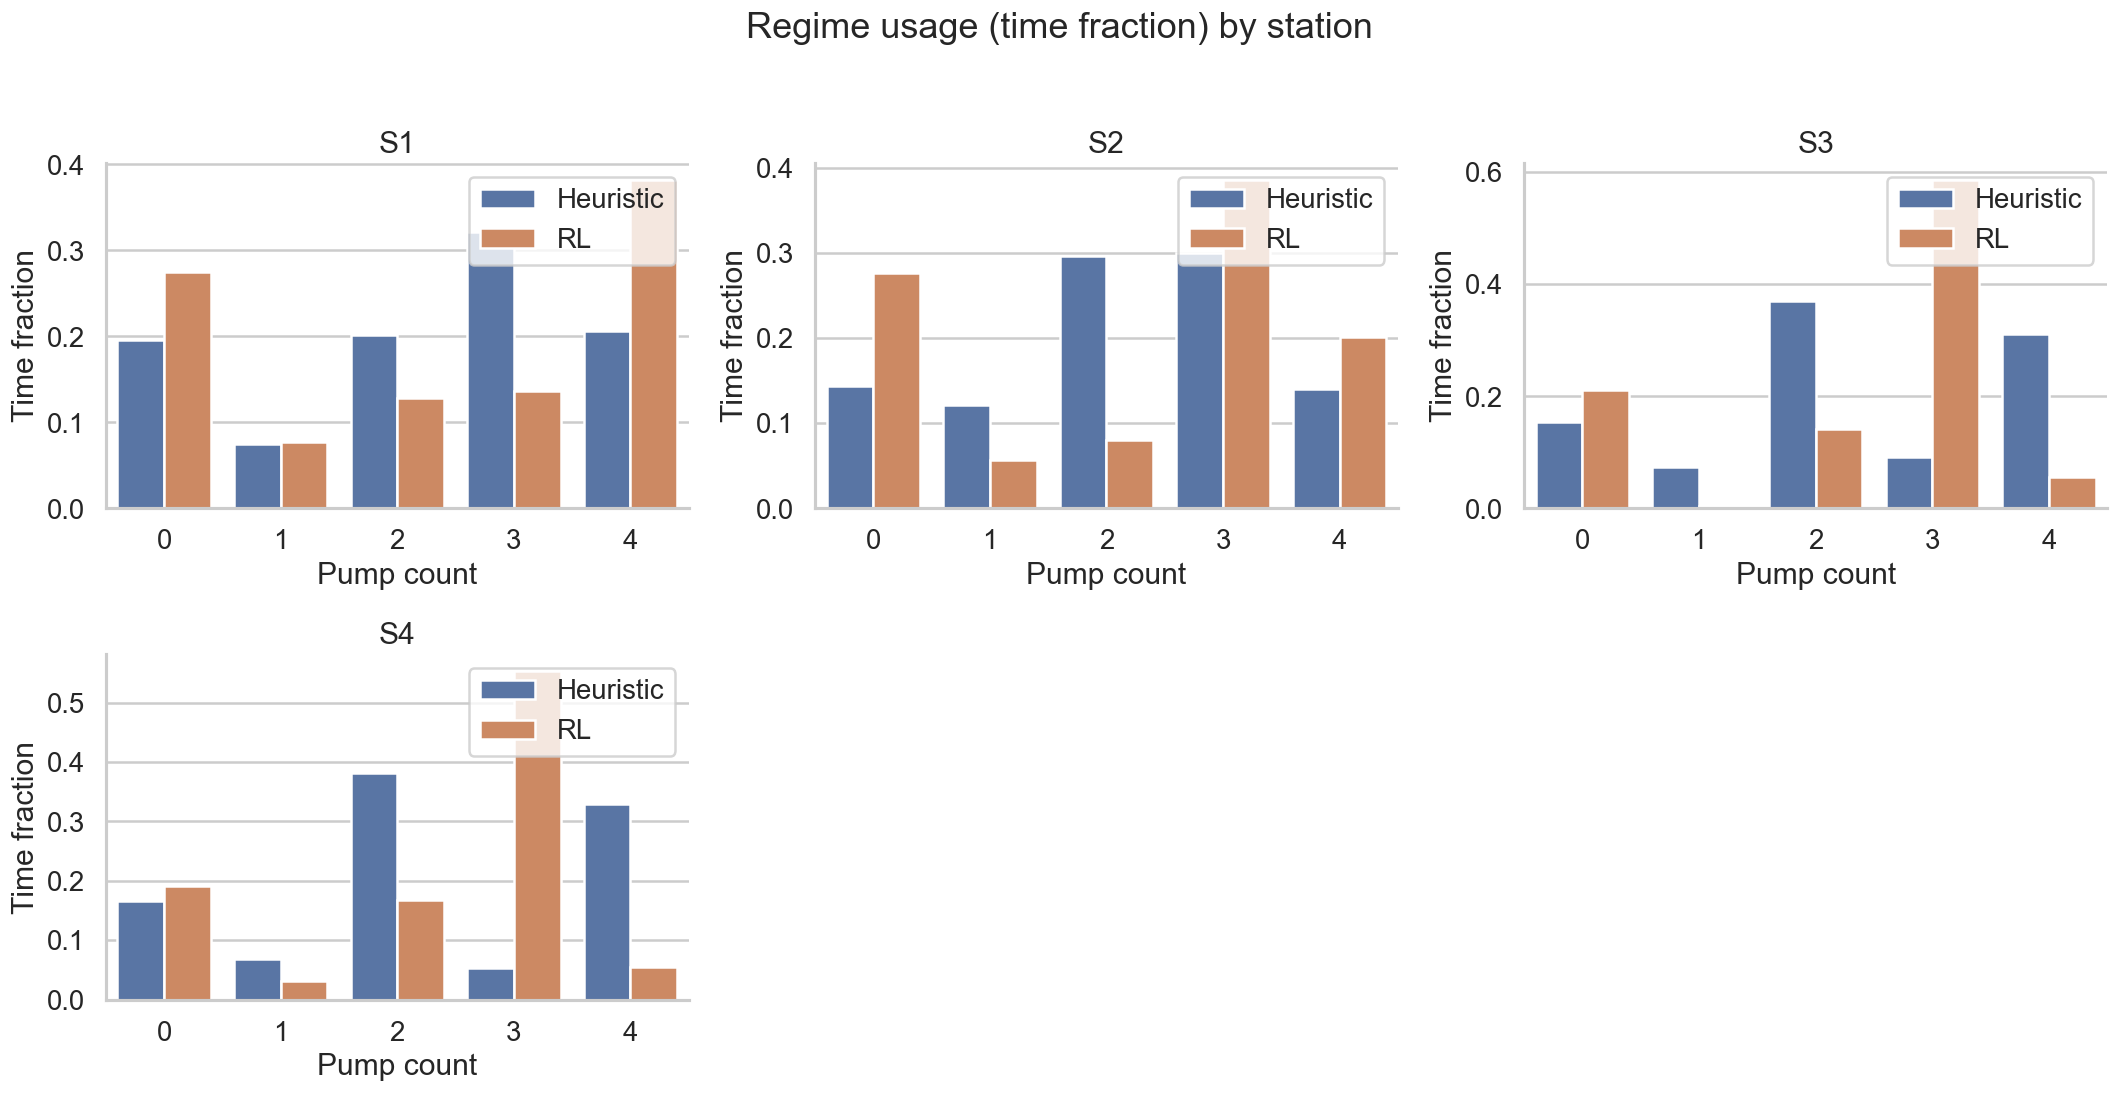

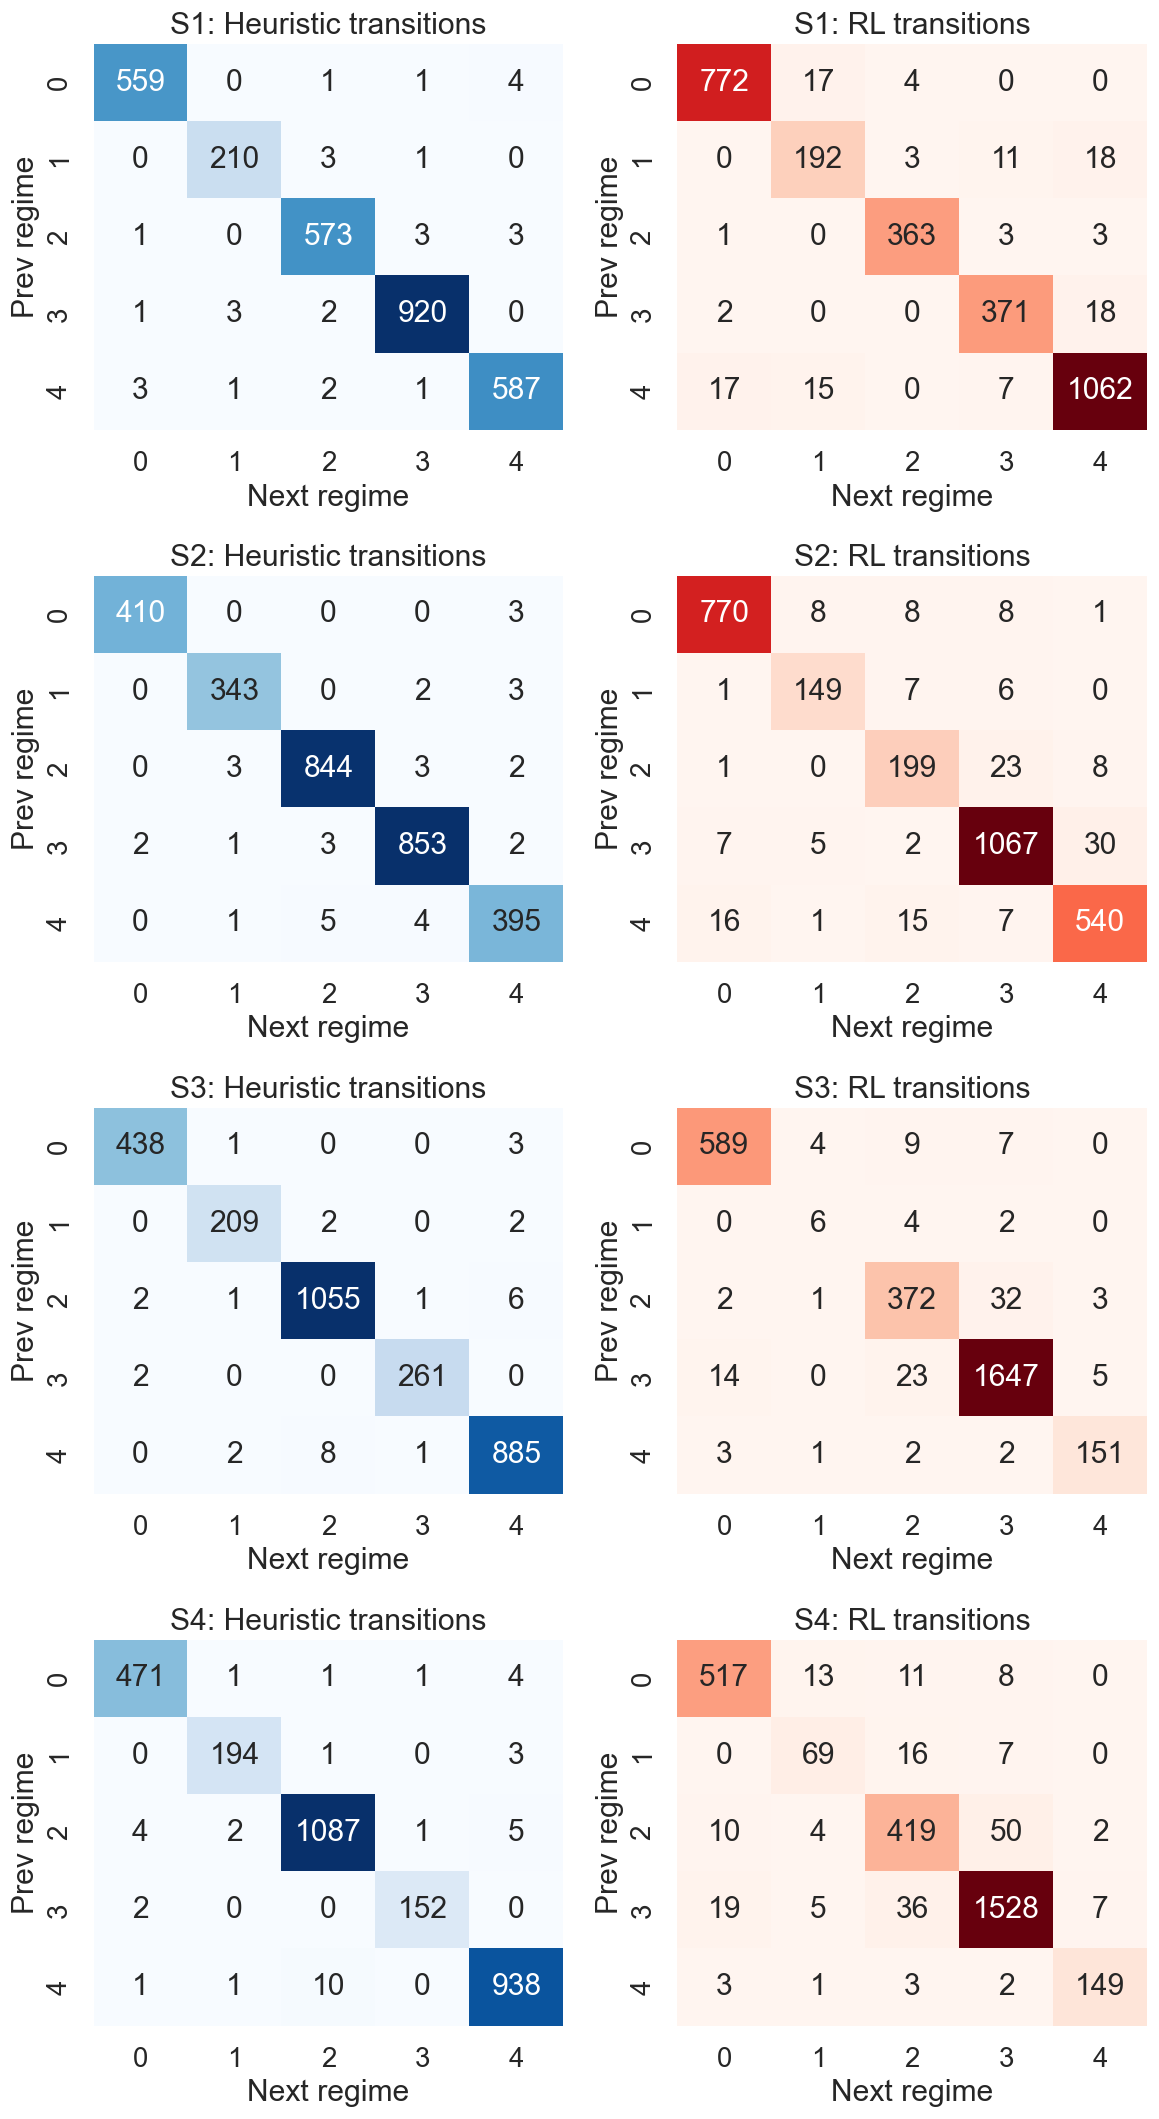

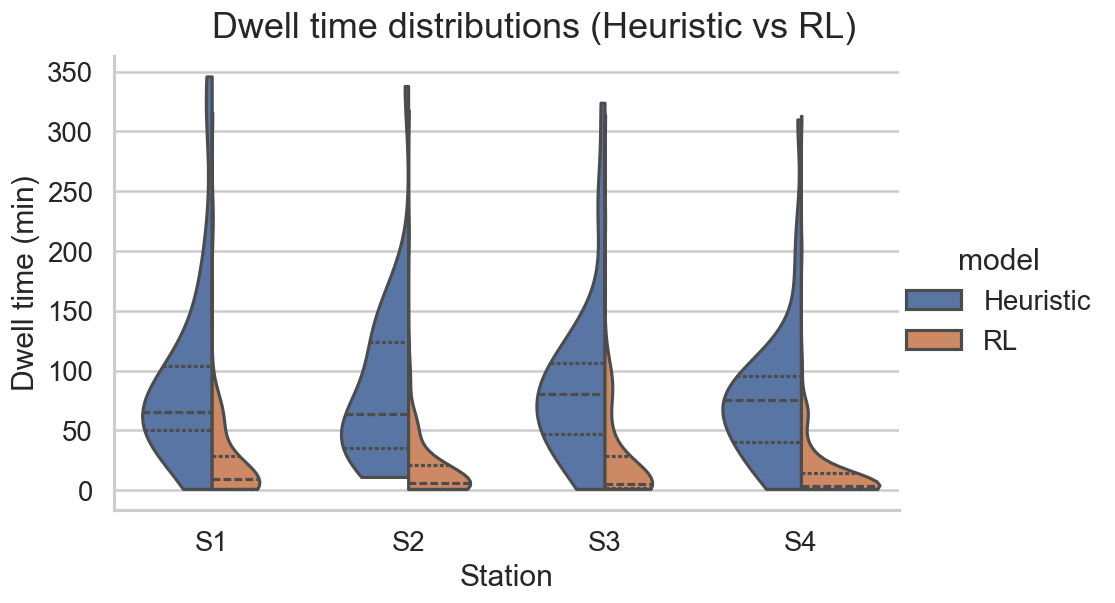

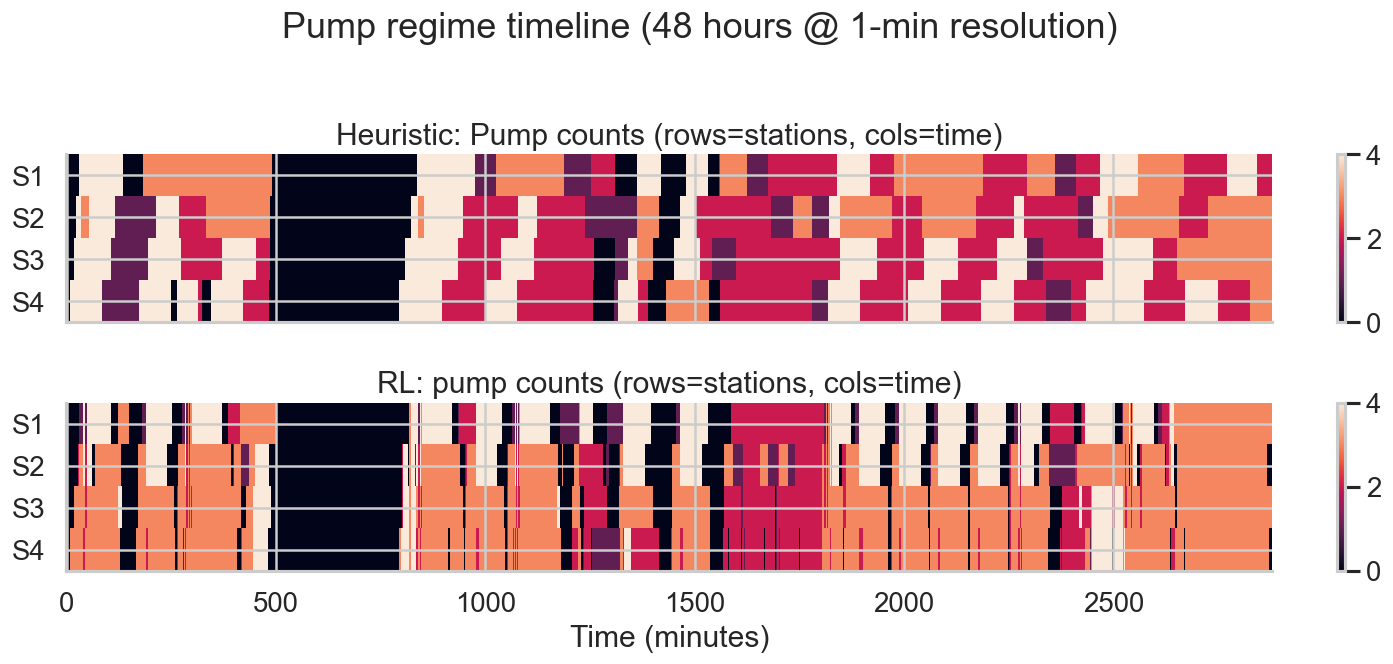

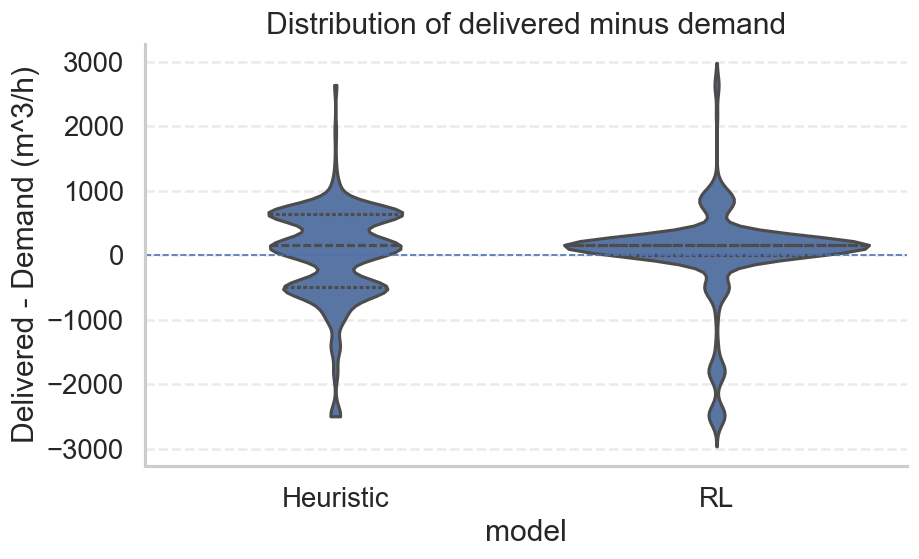

In [4]:

#Arbitrary fold - I could use Plotly to visualise all folds 
fold = 3

heur_actions, rl_actions, test_series = fetch_actions_for_fold(
    demand_df=demand_df,
    regimes_list=regimes_list,
    fold=fold,
    best_heuristic_params=(0.02, 50.0),  # from your global best
    best_rl_params=(10.0, 1.0),          # from your global best
    safety_lower=0.32,
    safety_upper=0.88,
    rl_seed=4242,
    rl_outer_episodes=12
)

# Sanity check (lengths should match)
assert len(test_series) == len(heur_actions) == len(rl_actions)

regimes_obj = prepare_regimes(regimes_list)
build_and_plot_all(
    regimes=regimes_obj,
    actions_heur=heur_actions,
    actions_rl=rl_actions,
    demand_series_m3_per_h=test_series,
    station_names=["S1", "S2", "S3", "S4"],
    timestep_hours=1.0/60.0
)



In [4]:
FOLDS: List[int] = [1, 2, 3, 4, 5]

# Heuristic outer-test (per fold)
HEUR_ENERGY: List[float] = [963755.74, 847943.63, 811516.59, 1172628.46, 945267.19]
HEUR_SWITCHES: List[int] = [119, 139, 132, 90, 118]

# RL outer-test (per-fold seed mean)
RL_ENERGY: List[float] = [956967.35, 835889.75, 801478.34, 1165205.66, 937956.56]
RL_SWITCHES: List[float] = [2262.1, 2023.7, 595.1, 4960.3, 697.7]

WINDOW_HOURS: float = 48.0  # each test window length

def make_results_df() -> pd.DataFrame:
    """Build a tidy DataFrame with fold-wise metrics for both models."""
    df_h = pd.DataFrame({
        "fold": FOLDS,
        "model": ["Heuristic"] * len(FOLDS),
        "energy_kwh": HEUR_ENERGY,
        "switches": HEUR_SWITCHES,
    })
    df_r = pd.DataFrame({
        "fold": FOLDS,
        "model": ["RL"] * len(FOLDS),
        "energy_kwh": RL_ENERGY,
        "switches": RL_SWITCHES,
    })
    df = pd.concat([df_h, df_r], ignore_index=True)
    df["switches_per_hour"] = df["switches"] / WINDOW_HOURS
    return df



print_summary(compute_all_stats(make_results_df()))

=== Energy (RL - Heuristic) ===
Deltas per fold (kWh): [ -6788., -12054., -10038.,  -7423.,  -7311.]
Median ΔE: -7423 kWh   95% CI [-12054, -6788]   Wilcoxon p=1.000
Sign test: wins=5, losses=0, one-sided p=0.031
Common-language effect size (P[RL < Heur]): 1.00

=== Switches (RL - Heuristic) ===
Deltas per fold (count): [2143., 1885.,  463., 4870.,  580.]
Median ΔS: 1885   95% CI [463, 4870]   Wilcoxon p=0.031
Sign test: wins=0, losses=5, one-sided p=1.000
Common-language effect size (P[RL < Heur]): 0.00


## Summary & Conclusions

Both models meet the constraints of keeping reservoirs levels within 30% - 90%  while meeting  water flow demand. Therefore, the choice is a trade-off between energy and switching cost.

**Energy**: The RL model's policy uses less energy than the proportional control heuristic model (henceforth, Heuristic model) on all the 5 test folds.

Per-fold ΔE = RL - Heuristic = [-6788; -12054; −10038; −7423; −7311 kWh].

Mean = −8723 kWh (~ −0.92%) with SD ~2250 kWh.

Sign test: 5/5 wins:  one-sided p ≈ 0.031 with alpha = 0.05.


**Switching**: The RL model's policy switches the pumps more often than the Heuristic model on all the 5 test folds. 

Per-fold ΔS = RL − Heuristic =
[+2143; +1885; +463; +4870; +580].

Mean = +1988 switches (SD ~1778).

To summarise, over a 48 hours test window, the RL model's policy relies on ~44 switches/hour (all stations combined) to meet the flow rate demand  against the Heuristic model's  ~2.5/hour rate of switches. In other words, the RL model's policy gives ~0.9% energy saving at the cost of ~17x more pumps switching.

The decision on whether to opt for one or the other policy hinges on the costs of switches and electricity.

Specifically, let *p* be the local energy price (local currency/kWh) and *c* the cost (maintenance + wear + ops etc.) of each switch, then if both models are equally economically viable, the total extra switching cost exactly cancels out the energy saving:

$$8723×p=1988×c$$

solving for *c* gives the *break-even* cost per switch:

$$  c= \frac{8723×p}{1988}$$


The best policy can then be chosen based on the value of *c* : If the real cost per switch is higher than *c*, then the extra switching cost outweights the energy savings (i.e., the Heuristic model's policy is preferable) otherwise, the energy savings justify the extra switching (i.e., the RL model's policy is preferable).

